In [2]:
import random
import numpy as np
import math
import scipy.special
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table

In [3]:
domains = {
    'x1': [i for i in range(0,16)],
    'x2': [i for i in range(0,11)],
    'x3': [i for i in range(0,26)],
    'x4': [i for i in range(0,5)],
    'x5': [i for i in range(0,31)],
}

In [4]:
costos=[164,310,46,111,12]

In [5]:
constraints = {
    ('x1', 'x2'): lambda x1, x2:  costos[0]*x1 <= 3800-costos[1]*x2,
    ('x2', 'x1'): lambda x2, x1:  3800-costos[1]*x2 >= costos[0]*x1,
    ('x3', 'x4'): lambda x3, x4:  costos[2]*x3 <= 2800-costos[3]*x4,
    ('x4', 'x3'): lambda x4, x3:  2800-costos[3]*x4 >= costos[2]*x3,
    ('x3', 'x5'): lambda x3, x5:  costos[2]*x3 <= 3500-costos[4]*x5,
    ('x5', 'x3'): lambda x5, x3:  3500-costos[4]*x5 >= costos[2]*x3,
}

In [6]:
def revise(x, y):
    revised = False
    x_domain = domains[x]
    y_domain = domains[y]
    all_constraints = [
        constraint for constraint in constraints if constraint[0] == x and constraint[1] == y]
    for x_value in x_domain:
        satisfies = False
        for y_value in y_domain:
            for constraint in all_constraints:
                constraint_func = constraints[constraint]
                if constraint_func(x_value, y_value):
                    satisfies = True
        if not satisfies:
            x_domain.remove(x_value)
            revised = True
    return revised

def ac3(arcs):
    queue = arcs[:]
    while queue:
        (x, y) = queue.pop(0)
        revised = revise(x, y)
        if revised:
            neighbors = [neighbor for neighbor in arcs if neighbor[1] == x]
            queue = queue + neighbors

In [7]:
arcs = [
    ('x1', 'x2'), ('x2', 'x1'),
    ('x3', 'x4'), ('x4', 'x3'),
    ('x3', 'x5') ,('x5', 'x3'),
]

In [8]:
ac3(arcs)

In [9]:
def sigmoide(x, alpha, x0):
    return 1/(1+np.exp(-alpha*(x-x0)))

In [10]:
def find_y_interval(y, intervals):
    interval_width = 1 / intervals
    for i in range(intervals):
        if i * interval_width <= y < (i + 1) * interval_width:
            return i
    return intervals - 1 if y == 1 else None

In [11]:
def master_sigmoide(arreglo):
    parameters = [
        (0.6, 7.5, 16),    
        (1, 5, 11),        
        (0.35, 12.5, 26),  
        (2.5, 2, 5),       
        (0.3, 15, 31)      
    ]
    
    results = []
    for x, (alpha, x0, intervals) in zip(arreglo, parameters):
        y = sigmoide(x, alpha, x0)
        if intervals == 5: 
            if 0 <= y < 0.2:
                results.append(0)
            elif 0.2 <= y < 0.4:
                results.append(1)
            elif 0.4 <= y < 0.6:
                results.append(2)
            elif 0.6 <= y < 0.8:
                results.append(3)
            elif 0.8 <= y <= 1:
                results.append(4)
            else:
                results.append(None)
        else:
            results.append(find_y_interval(y, intervals))
    
    return results

In [12]:
def maximizar(x):
    x1,x2,x3,x4,x5=x
    return 67*x1+91*x2+43*x3+71*x4+23*x5

In [13]:
def minimizar(x):
    x1,x2,x3,x4,x5=x
    return 164*x1+310*x2+46*x3+111*x4+12*x5

In [14]:
def restricciones(x):
    x1,x2,x3,x4,x5=x
    return (0<= x1 and x1<=15 and 0<=x2 and x2<=10 and 0<=x3 and x3<=25 and 0<=x4 and x4<=4 and 0<=x5 and x5<=30 \
            and 164*x1+310*x2<=3800 and 46*x3+111*x4<= 2800 and 46*x3+13*x5<= 3500)

In [15]:
def scalarizing(x, wmax, wmin):
    cap=4000
    fracmax=(maximizar(x))/3418
    fracmin=(cap-(minimizar(x))) / (cap-0)
    return wmax*fracmax + wmin*fracmin

In [16]:
def Cl() -> float:
    return random.uniform(0.674,1.5)

In [17]:
def gliding():
    ro = 1.204#𝜌
    hg = 8
    V = 5.25
    S = 154
    Gc = 1.9
    Cd = 0.60
    L = 1 / 2 * (ro * (Cl()) * (V**2) * S)
    D = 1 / 2 * (ro * (V**2) * S * Cd)
    artc = np.arctan(D / L)
    dg = hg / np.tan(artc)
    sf = 18
    return dg / sf


In [18]:
def rho():
    beta=1.5
    return ((scipy.special.gamma(beta+1)*np.sin((math.pi*beta)/2))/ \
     (scipy.special.gamma((1+beta)/2)*beta*(2)**((beta-1)/2)))**(1/beta)

In [19]:
lower_band=[domains[f"x{i+1}"][0] for i in range(len(domains.keys()))]
upper_band=[domains[f"x{i+1}"][-1] for i in range(len(domains.keys()))]

In [20]:
def levy():
    beta = 1.5
    sigma = (scipy.special.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
             (scipy.special.gamma((1 + beta) / 2) * beta * 2**((beta - 1) / 2)))**(1 / beta)
    u = np.random.normal(0, sigma, size=len(lower_band)) 
    v = np.random.normal(0, 1, size=len(lower_band)) 
    step = u / np.abs(v)**(1 / beta)
    return 0.01 * step

In [21]:
def randomloc(index):
    return lower_band[index] + levy()[index] * (upper_band[index] - lower_band[index]) 

In [22]:
def actualizar_valores(i, ref_vector, Pdp):
    for u, v in enumerate(i):
        if random.uniform(0, 1) >= Pdp:
            new_value = v + gliding() * 1.9 * (ref_vector[u] - v)
        else:
            new_value = randomloc(u)
        i[u] = new_value
    return master_sigmoide(np.clip(i, lower_band, upper_band))

In [23]:
def Smin(t,maxiter):
    return (10 * 10**-6)/(365**(t/(maxiter/2.5)))

In [24]:
def main(maxiter,popsize,wmax,wmin):
    FS=[]
    for i in range(popsize):
        while True:
            aux=master_sigmoide([random.uniform(lower_band[j], upper_band[j]) for j in range(len(lower_band))])
            if restricciones(aux):
                break
        FS.append(aux)

    fitness_values = [scalarizing(ind,wmax,wmin) for ind in FS]

    FS = [x for _, x in sorted(zip(fitness_values, FS), key=lambda pair: pair[0])]

    trees = [1]
    if popsize > 1:
        trees.extend([2] * min(popsize - 1, 3))
    if popsize > 4:
        trees.extend(random.randint(3, 4) for _ in range(popsize - 4))
    Pdp=0.01

    for iterable in range(maxiter):
        Sc = []
        for j, i in enumerate(FS[1:4]):
            resta = 0
            while True:
                FS[j + 1] = actualizar_valores(i, FS[0], Pdp)
                if restricciones(FS[j + 1]):
                    break
            resta = np.array(i) - np.array(FS[0])
            resta = np.sqrt(np.sum(resta**2))
            Sc.append(resta)

        for idx, j in enumerate(FS[4:]):
            if trees[idx + 4] == 3:
                ref_vector = random.choice(FS[1:4])
            else:
                ref_vector = FS[0]
        
            while True:
                FS[idx + 4] = actualizar_valores(j, ref_vector, Pdp)
                if restricciones(FS[idx + 4]):
                    break
                
        for idx, value in enumerate(Sc):
            if value < Smin(iterable, maxiter):
                while True:
                    for i in range(len(FS[idx + 1])):
                        FS[idx + 1][i] = randomloc(i)

                    FS[idx + 1] = master_sigmoide(np.clip(FS[idx + 1], lower_band, upper_band))
                    if restricciones(FS[idx + 1]):
                        break

        fitness_values = [scalarizing(ind,wmax,wmin) for ind in FS]

        FS = [x for _, x in sorted(zip(fitness_values, FS), key=lambda pair: pair[0])]

        trees = [1]
        if popsize > 1:
            trees.extend([2] * min(popsize - 1, 3))
        if popsize > 4:
            trees.extend(random.randint(3, 4) for _ in range(popsize - 4))
            
    return FS

In [25]:
repeticiones=10
resultados={}
for i in np.arange(0.0, 1.1, 0.01):
    # print(f"{i}-{1-i}")
    resultados[f"{i}-{1-i}"]=[]
    cons=Console()
    tabla=Table(title=f"SSA FS resultantes con factores {i} y {1-i}",show_header=True,header_style="bold magenta")
    tabla.add_column("FS",justify="full",no_wrap=True)
    tabla.add_column("Maximizacion",style="dim",justify="full",no_wrap=True)
    tabla.add_column("Minimizacion",style="dim",justify="full")
    tabla.add_column("Scalarizing",style="dim",justify="full")
    tabla.add_column("Restricciones",style="dim",justify="full")
    for j in range(repeticiones):
        FS=main(100,10,i,1-i)
        resultados[f"{i}-{1-i}"].append([maximizar(FS[0]),minimizar(FS[0])])
        for j in FS:
            tabla.add_row(str(j),str(maximizar(j)),str(minimizar(j)),str(scalarizing(j,i,1-i)),str(restricciones(j)))
    cons.print(tabla)

                    SSA FS resultantes con factores 0.0 y 1.0                     
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.4275     │ True          │
│ [2, 10, 25, 4, 30] │ 3093         │ 5382         │ -0.3455     │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ -0.3045     │ True          │
│ [1, 10, 22, 4, 30] │ 2897         │ 5080         │ -0.27       │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2635     │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2635     │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2635     │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2635     │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2635     │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 1.0         │ True          │
│ [15, 4, 25, 0, 30] │ 3134         │ 5210         │ -0.3025     │ True          │
│ [15, 3, 25, 0, 30] │ 3043         │ 4900         │ -0.225      │ True          │
│ [15, 3, 25, 0, 30] │ 3043         │ 4900         │ -0.225      │ True          │
│ [15, 3, 25, 0, 30] │ 3043         │ 4900         │ -0.225      │ True          │
│ [15, 2, 25, 0, 30] │ 2952         │ 4590         │ -0.1475     │ True          │
│ [15, 1, 25, 0, 30] │ 2861         │ 4280         │ -0.07       │ True          │
│ [15, 1, 25, 0, 22] │ 2677         │ 4184         │ -0.046      │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.0075      │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.0075      │ True          │
│ [15, 0, 1, 0, 28]  │ 1692         │ 2842         │ 0.2895      │ True          │
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.4275     │ True          │
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.4275     │ True          │
│ [3, 10, 25, 4, 30] │ 3160         │ 5546         │ -0.3865     │ True          │
│ [2, 10, 25, 4, 30] │ 3093         │ 5382         │ -0.3455     │ True          │
│ [2, 10, 25, 4, 30] │ 3093         │ 5382         │ -0.3455     │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ -0.3045     │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ -0.3045     │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2635     │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2635     │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2635     │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.3235     │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.3235     │ True          │
│ [15, 2, 25, 4, 0]  │ 2546         │ 4674         │ -0.1685     │ True          │
│ [15, 2, 25, 4, 0]  │ 2546         │ 4674         │ -0.1685     │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ -0.091      │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ -0.091      │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ -0.091      │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ -0.0135     │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ -0.0135     │ True          │
│ [15, 0, 25, 0, 0]  │ 2080         │ 3610         │ 0.0975      │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2635     │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2635     │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2635     │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2635     │ True          │
│ [0, 10, 25, 4,

                        SSA FS resultantes con factores 0.01 y 0.99                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [1, 10, 25, 0, 30] │ 2742         │ 4774         │ -0.18354276477472206  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.14314878583967233  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.14314878583967233  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.14314878583967233  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.14314878583967233  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.14314878583967233  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.14314878583967233  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.14314878583967233  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.14314878583967233  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.14314878583967233  │ True          │
│ [4, 10, 0, 4, 30]  │ 2152         │ 4560         │ -0.13230392042129901  │ True          │
│ [2, 10, 0, 4, 30]  │ 2018         │ 4232         │ -0.051515962551199536 │ True          │
│ [2, 10, 0, 4, 30]  │ 2018         │ 4232         │ -0.051515962551199536 │ True          │
│ [1, 10, 0, 4, 30]  │ 1951         │ 4068         │ -0.011121983616149796 │ True          │
│ [1, 10, 0, 4, 30]  │ 1951         │ 4068         │ -0.011121983616149796 │ True          │
│ [1, 10, 0, 4, 30]  │ 1951         │ 4068         │ -0.011121983616149796 │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.029271995318899943  │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.029271995318899943  │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.029271995318899943  │ True          │
│ [0, 10, 0, 0, 0]   │ 910          │ 3100         │ 0.2254123756582797    │ True          │
│ [1, 10, 25, 4, 28] │ 2980         │ 5194         │ -0.2867964511410181   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.25220789057928616  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.25220789057928616  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.25220789057928616  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.25220789057928616  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.25220789057928616  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.25220789057928616  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.25220789057928616  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.25220789057928616  │ True          │
│ [0, 10, 25, 4, 29] │ 2936         │ 5042         │ -0.24930518139262725  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.25220789057928616  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.25220789057928616  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.25220789057928616  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.25220789057928616  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.25220789057928616  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.25220789057928616  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.25220789057928616  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.99                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.99                  │ True          │
│

                        SSA FS resultantes con factores 0.02 y 0.98                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [1, 10, 24, 4, 0]  │ 2293         │ 4812         │ -0.18552279695728496  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.15675322995904037  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.15675322995904037  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.15675322995904037  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.15675322995904037  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.15675322995904037  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.15675322995904037  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.15675322995904037  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.15675322995904037  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.15675322995904037  │ True          │
│ [4, 10, 25, 4, 0]  │ 2537         │ 5350         │ -0.31590506143943825  │ True          │
│ [4, 10, 25, 4, 0]  │ 2537         │ 5350         │ -0.31590506143943825  │ True          │
│ [3, 10, 25, 4, 0]  │ 2470         │ 5186         │ -0.2761171035693388   │ True          │
│ [2, 10, 25, 4, 0]  │ 2403         │ 5022         │ -0.23632914569923932  │ True          │
│ [2, 10, 25, 4, 0]  │ 2403         │ 5022         │ -0.23632914569923932  │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ -0.19654118782913982  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.15675322995904037  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.15675322995904037  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.15675322995904037  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.15675322995904037  │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.38522999999999996  │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.38522999999999996  │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.38522999999999996  │ True          │
│ [15, 3, 25, 4, 30] │ 3327         │ 5344         │ -0.30981247513165594  │ True          │
│ [15, 2, 25, 4, 30] │ 3236         │ 5034         │ -0.23439495026331186  │ True          │
│ [15, 1, 25, 4, 30] │ 3145         │ 4724         │ -0.1589774253949678   │ True          │
│ [15, 1, 25, 4, 30] │ 3145         │ 4724         │ -0.1589774253949678   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.08355990052662375  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.08355990052662375  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.98                  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2409157811585723   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2409157811585723   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2409157811585723   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2409157811585723   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2409157811585723   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.2409157811585723   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.15675322995904037  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.98                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.98                  │ True          │
│

                        SSA FS resultantes con factores 0.03 y 0.97                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.14837984493856055  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.14837984493856055  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.14837984493856055  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.14837984493856055  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.14837984493856055  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.14837984493856055  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.14837984493856055  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.97                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.97                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.97                  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.07358985078993563  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.07358985078993563  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.07358985078993563  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.07358985078993563  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.07358985078993563  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.07358985078993563  │ True          │
│ [15, 0, 0, 4, 30]  │ 1979         │ 3264         │ 0.1958498069046226    │ True          │
│ [15, 0, 0, 4, 30]  │ 1979         │ 3264         │ 0.1958498069046226    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.97                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.97                  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.22962367173785841  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.22962367173785841  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.22962367173785841  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.22962367173785841  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.22962367173785841  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.22962367173785841  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.22962367173785841  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.97                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.97                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.97                  │ True          │
│ [1, 10, 25, 4, 1]  │ 2359         │ 4870         │ -0.19026990930368637  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.14837984493856055  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.14837984493856055  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.14837984493856055  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.14837984493856055  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.14837984493856055  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.14837984493856055  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.14837984493856055  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.14837984493856055  │ True          │
│

                        SSA FS resultantes con factores 0.04 y 0.96                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.0636198010532475   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.0636198010532475   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.0636198010532475   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.0636198010532475   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.0636198010532475   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.0636198010532475   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.0636198010532475   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.0636198010532475   │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.03961661790520772   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.96                  │ True          │
│ [15, 1, 24, 4, 28] │ 3056         │ 4654         │ -0.12119639555295493  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.0636198010532475   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.0636198010532475   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.0636198010532475   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.0636198010532475   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.0636198010532475   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.0636198010532475   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.0636198010532475   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.0636198010532475   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.0636198010532475   │ True          │
│ [1, 10, 23, 4, 29] │ 2917         │ 5114         │ -0.23322307782328852  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.21833156231714454  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.21833156231714454  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.21833156231714454  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.21833156231714454  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.21833156231714454  │ True          │
│ [0, 10, 24, 4, 30] │ 2916         │ 5008         │ -0.20779478057343476  │ True          │
│ [0, 0, 25, 4, 30]  │ 2049         │ 1954         │ 0.5150189350497366    │ True          │
│ [0, 0, 25, 4, 30]  │ 2049         │ 1954         │ 0.5150189350497366    │ True          │
│ [0, 0, 25, 4, 30]  │ 2049         │ 1954         │ 0.5150189350497366    │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.21833156231714454  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.21833156231714454  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.21833156231714454  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.21833156231714454  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.21833156231714454  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.21833156231714454  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.21833156231714454  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.96                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.96                  │ True          │
│

                        SSA FS resultantes con factores 0.05 y 0.95                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.1316330748976009   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.1316330748976009   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.1316330748976009   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.1316330748976009   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.1316330748976009   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.1316330748976009   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.1316330748976009   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.95                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.95                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.95                  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.95                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.95                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.95                  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.95                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.95                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.95                  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.20703945289643066  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.1316330748976009   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.95                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.95                  │ True          │
│

                         SSA FS resultantes con factores 0.06 y 0.94                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing            ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [4, 10, 25, 0, 0]  │ 2253         │ 4906         │ -0.17336055588063193   │ True          │
│ [2, 10, 25, 0, 0]  │ 2119         │ 4578         │ -0.09863280866003508   │ True          │
│ [2, 10, 25, 0, 0]  │ 2119         │ 4578         │ -0.09863280866003508   │ True          │
│ [2, 10, 25, 0, 0]  │ 2119         │ 4578         │ -0.09863280866003508   │ True          │
│ [1, 10, 25, 0, 0]  │ 2052         │ 4414         │ -0.06126893504973668   │ True          │
│ [1, 10, 25, 0, 0]  │ 2052         │ 4414         │ -0.06126893504973668   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ -0.02390506143943827   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ -0.02390506143943827   │ True          │
│ [0, 0, 25, 0, 0]   │ 1075         │ 1150         │ 0.6886206846108835     │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.94                   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.1957473434757168    │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.1957473434757168    │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.1957473434757168    │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.1957473434757168    │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.1957473434757168    │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.1957473434757168    │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.1232596898771211    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.94                   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.94                   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.94                   │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.32869               │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.32869               │ True          │
│ [15, 2, 25, 4, 30] │ 3236         │ 5034         │ -0.18618485078993563   │ True          │
│ [15, 1, 25, 4, 30] │ 3145         │ 4724         │ -0.11493227618490344   │ True          │
│ [15, 1, 25, 4, 30] │ 3145         │ 4724         │ -0.11493227618490344   │ True          │
│ [15, 1, 25, 4, 29] │ 3122         │ 4712         │ -0.11251602106495023   │ True          │
│ [15, 1, 24, 4, 30] │ 3102         │ 4678         │ -0.1048771035693388    │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.043679701579871257  │ True          │
│ [15, 0, 0, 4, 30]  │ 1979         │ 3264         │ 0.20769961380924515    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.94                   │ True          │
│ [15, 1, 25, 4, 15] │ 2800         │ 4544         │ -0.07868844938560562   │ True          │
│ [15, 0, 25, 4, 18] │ 2778         │ 4270         │ -0.014684640140433011  │ True          │
│ [15, 0, 25, 4, 13] │ 2663         │ 4210         │ -0.0026033645406670566 │ True          │
│ [15, 0, 25, 4, 11] │ 2617         │ 4186         │ 0.002229145699239321   │ True          │
│ [15, 0, 25, 4, 9]  │ 2571         │ 4162         │ 0.007061655939145699   │ True          │
│ [15, 0, 25, 4, 6]  │ 2502         │ 4126         │ 0.014310421299005269   │ True          │
│ [15, 0, 25, 4, 1]  │ 2387         │ 4066         │ 0.026391696898771213   │ True          │
│ [15, 0, 25, 4, 1]  │ 2387         │ 4066         │ 0.026391696898771213   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │

                 SSA FS resultantes con factores 0.07 y 0.9299999999999999                  
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.314555             │ True          │
│ [15, 2, 25, 4, 30] │ 3236         │ 5034         │ -0.17413232592159156  │ True          │
│ [15, 2, 25, 4, 30] │ 3236         │ 5034         │ -0.17413232592159156  │ True          │
│ [15, 3, 25, 0, 30] │ 3043         │ 4900         │ -0.1469299297834991   │ True          │
│ [15, 1, 25, 4, 30] │ 3145         │ 4724         │ -0.10392098888238734  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.03370965184318313  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.03370965184318313  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ -0.03370965184318313  │ True          │
│ [9, 0, 0, 4, 13]   │ 1186         │ 2076         │ 0.4716190579286132    │ True          │
│ [0, 0, 24, 4, 30]  │ 2006         │ 1908         │ 0.5274725043885313    │ True          │
│ [4, 10, 25, 0, 30] │ 2943         │ 5266         │ -0.23407291105909886  │ True          │
│ [3, 10, 25, 0, 30] │ 2876         │ 5102         │ -0.19731505851375075  │ True          │
│ [2, 10, 25, 0, 30] │ 2809         │ 4938         │ -0.16055720596840253  │ True          │
│ [2, 10, 25, 0, 30] │ 2809         │ 4938         │ -0.16055720596840253  │ True          │
│ [2, 10, 25, 0, 30] │ 2809         │ 4938         │ -0.16055720596840253  │ True          │
│ [1, 10, 25, 0, 30] │ 2742         │ 4774         │ -0.12379935342305441  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.08704150087770623  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.08704150087770623  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.08704150087770623  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.9299999999999999    │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.18445523405500291  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.18445523405500291  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.18445523405500291  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.18445523405500291  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.18445523405500291  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.18445523405500291  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.08704150087770623  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.9299999999999999    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.9299999999999999    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.9299999999999999    │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.08704150087770623  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.08704150087770623  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.08704150087770623  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.08704150087770623  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.08704150087770623  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.08704150087770623  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.08704150087770623  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.9299999999999999    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.9299999999999999    │ True          │
│

                        SSA FS resultantes con factores 0.08 y 0.92                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [15, 4, 25, 4, 2]  │ 2774         │ 5318         │ -0.2382131421884143   │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.23376979520187244  │ True          │
│ [15, 2, 25, 4, 0]  │ 2546         │ 4674         │ -0.09542959625511996  │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ -0.02625949678174371  │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ -0.02625949678174371  │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ -0.02625949678174371  │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.042910602691632535  │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.042910602691632535  │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.042910602691632535  │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.042910602691632535  │ True          │
│ [4, 10, 25, 0, 0]  │ 2253         │ 4906         │ -0.1556474078408426   │ True          │
│ [1, 10, 25, 0, 0]  │ 2052         │ 4414         │ -0.04719191339964892  │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ -0.01104008191925103  │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ -0.01104008191925103  │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ -0.01104008191925103  │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ -0.01104008191925103  │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ -0.01104008191925103  │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ -0.01104008191925103  │ True          │
│ [0, 10, 0, 0, 0]   │ 910          │ 3100         │ 0.2282990052662376    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.92                  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.17316312463428907  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.17316312463428907  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.17316312463428907  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.17316312463428907  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.17316312463428907  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.17316312463428907  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.17316312463428907  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.92                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.92                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.92                  │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.23376979520187244  │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.23376979520187244  │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.23376979520187244  │ True          │
│ [15, 3, 25, 4, 0]  │ 2637         │ 4984         │ -0.1645996957284962   │ True          │
│ [15, 2, 25, 4, 0]  │ 2546         │ 4674         │ -0.09542959625511996  │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ -0.02625949678174371  │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ -0.02625949678174371  │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.042910602691632535  │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.042910602691632535  │ True          │
│

                        SSA FS resultantes con factores 0.09 y 0.91                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [4, 10, 2, 4, 0]   │ 1548         │ 4292         │ -0.025669321240491517 │ True          │
│ [2, 10, 0, 4, 0]   │ 1328         │ 3872         │ 0.06408781743709771   │ True          │
│ [2, 10, 0, 4, 0]   │ 1328         │ 3872         │ 0.06408781743709771   │ True          │
│ [4, 10, 0, 0, 0]   │ 1178         │ 3756         │ 0.08652813926272675   │ True          │
│ [1, 10, 0, 4, 0]   │ 1261         │ 3708         │ 0.09963362785254534   │ True          │
│ [0, 10, 0, 4, 0]   │ 1194         │ 3544         │ 0.135179438267993     │ True          │
│ [0, 10, 0, 4, 0]   │ 1194         │ 3544         │ 0.135179438267993     │ True          │
│ [0, 10, 0, 4, 0]   │ 1194         │ 3544         │ 0.135179438267993     │ True          │
│ [0, 10, 0, 4, 0]   │ 1194         │ 3544         │ 0.135179438267993     │ True          │
│ [0, 10, 0, 4, 0]   │ 1194         │ 3544         │ 0.135179438267993     │ True          │
│ [4, 10, 25, 4, 0]  │ 2537         │ 5350         │ -0.24032277647747224  │ True          │
│ [4, 10, 25, 4, 0]  │ 2537         │ 5350         │ -0.24032277647747224  │ True          │
│ [4, 10, 25, 4, 0]  │ 2537         │ 5350         │ -0.24032277647747224  │ True          │
│ [2, 10, 25, 4, 0]  │ 2403         │ 5022         │ -0.16923115564657698  │ True          │
│ [2, 10, 25, 4, 0]  │ 2403         │ 5022         │ -0.16923115564657698  │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ -0.13368534523112932  │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ -0.13368534523112932  │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ -0.13368534523112932  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.09813953481568169  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.09813953481568169  │ True          │
│ [15, 4, 25, 4, 2]  │ 2774         │ 5318         │ -0.22680228496196608  │ True          │
│ [15, 2, 25, 4, 1]  │ 2569         │ 4686         │ -0.08842017846693975  │ True          │
│ [15, 2, 25, 4, 0]  │ 2546         │ 4674         │ -0.08629579578700998  │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ -0.01816693387946168  │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ -0.01816693387946168  │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ -0.01816693387946168  │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ -0.01816693387946168  │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.04996192802808659   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.04996192802808659   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.04996192802808659   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.16187101521357522  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.16187101521357522  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.16187101521357522  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.16187101521357522  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.16187101521357522  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.16187101521357522  │ True          │
│ [0, 0, 25, 4, 30]  │ 2049         │ 1954         │ 0.5194176038619075    │ True          │
│ [0, 0, 1, 0, 0]    │ 43           │ 46           │ 0.9006672410766531    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.91                  │ True          │
│

                         SSA FS resultantes con factores 0.1 y 0.9                          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.15057890579286135  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.15057890579286135  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.15057890579286135  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.15057890579286135  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.15057890579286135  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.15057890579286135  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.15057890579286135  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.9                   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.9                   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.9                   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.15057890579286135  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.15057890579286135  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.15057890579286135  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.15057890579286135  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.15057890579286135  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.15057890579286135  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.15057890579286135  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.9                   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.9                   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.9                   │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.21133724400234055  │ True          │
│ [15, 2, 25, 4, 0]  │ 2546         │ 4674         │ -0.07716199531889995  │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ -0.010074370977179642 │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ -0.010074370977179642 │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ -0.010074370977179642 │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.05701325336454067   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.05701325336454067   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.05701325336454067   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.05701325336454067   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.9                   │ True          │
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.2903380631948508   │ True          │
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.2903380631948508   │ True          │
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.2903380631948508   │ True          │
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.2903380631948508   │ True          │
│ [3, 10, 25, 4, 30] │ 3160         │ 5546         │ -0.25539827384435343  │ True          │
│ [3, 10, 25, 4, 30] │ 3160         │ 5546         │ -0.25539827384435343  │ True          │
│ [2, 10, 25, 4, 30] │ 3093         │ 5382         │ -0.22045848449385605  │ True          │
│ [2, 10, 25, 4, 30] │ 3093         │ 5382         │ -0.22045848449385605  │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ -0.1855186951433587   │ True          │
│

                         SSA FS resultantes con factores 0.11 y 0.89                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing            ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.258015              │ True          │
│ [15, 3, 25, 4, 30] │ 3327         │ 5344         │ -0.1919686132241077    │ True          │
│ [15, 1, 25, 4, 30] │ 3145         │ 4724         │ -0.059875839672323     │ True          │
│ [15, 1, 25, 4, 30] │ 3145         │ 4724         │ -0.059875839672323     │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.006170547103569346   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.006170547103569346   │ True          │
│ [15, 3, 0, 4, 30]  │ 2252         │ 4194         │ 0.029310131655939146   │ True          │
│ [11, 2, 1, 0, 0]   │ 962          │ 2470         │ 0.37138462551199536    │ True          │
│ [0, 2, 25, 4, 30]  │ 2231         │ 2574         │ 0.3890842978349912     │ True          │
│ [0, 1, 24, 4, 15]  │ 1752         │ 2038         │ 0.49292885020479815    │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.258015              │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.258015              │ True          │
│ [15, 3, 25, 4, 30] │ 3327         │ 5344         │ -0.1919686132241077    │ True          │
│ [15, 2, 25, 4, 30] │ 3236         │ 5034         │ -0.12592222644821535   │ True          │
│ [15, 2, 25, 4, 30] │ 3236         │ 5034         │ -0.12592222644821535   │ True          │
│ [15, 1, 25, 4, 30] │ 3145         │ 4724         │ -0.059875839672323     │ True          │
│ [15, 1, 24, 4, 16] │ 2780         │ 4510         │ -0.024007475131655936  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.006170547103569346   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.006170547103569346   │ True          │
│ [2, 1, 25, 2, 30]  │ 2132         │ 2370         │ 0.43128822410766526    │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.13928679637214747   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.13928679637214747   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.13928679637214747   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.13928679637214747   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.13928679637214747   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.13928679637214747   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.13928679637214747   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.89                   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.89                   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.89                   │ True          │
│ [15, 1, 25, 0, 30] │ 2861         │ 4280         │ 0.029774312463428904   │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.09582069923932124    │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.09582069923932124    │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.09582069923932124    │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.09582069923932124    │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.09582069923932124    │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.09582069923932124    │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.09582069923932124    │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │

                        SSA FS resultantes con factores 0.12 y 0.88                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing          ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [2, 10, 25, 4, 0]  │ 2403         │ 5022         │ -0.14047487419543594 │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ -0.10674712697483911 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.07301937975424223 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.07301937975424223 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.07301937975424223 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.07301937975424223 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.07301937975424223 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.07301937975424223 │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.88                 │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.88                 │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.24387999999999999 │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.24387999999999999 │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.24387999999999999 │ True          │
│ [15, 3, 25, 4, 30] │ 3327         │ 5344         │ -0.17887485078993565 │ True          │
│ [15, 3, 25, 4, 30] │ 3327         │ 5344         │ -0.17887485078993565 │ True          │
│ [15, 2, 25, 4, 30] │ 3236         │ 5034         │ -0.1138697015798713  │ True          │
│ [15, 1, 25, 4, 30] │ 3145         │ 4724         │ -0.04886455236980691 │ True          │
│ [15, 1, 25, 4, 30] │ 3145         │ 4724         │ -0.04886455236980691 │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.016140596840257468 │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.016140596840257468 │ True          │
│ [4, 10, 25, 0, 30] │ 2943         │ 5266         │ -0.17519641895845522 │ True          │
│ [4, 10, 25, 0, 30] │ 2943         │ 5266         │ -0.17519641895845522 │ True          │
│ [2, 10, 25, 0, 30] │ 2809         │ 4938         │ -0.10774092451726154 │ True          │
│ [2, 10, 25, 0, 30] │ 2809         │ 4938         │ -0.10774092451726154 │ True          │
│ [1, 10, 25, 0, 30] │ 2742         │ 4774         │ -0.07401317729666473 │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.04028543007606787 │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.04028543007606787 │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.04028543007606787 │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.88                 │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.88                 │ True          │
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.26290567583382096 │ True          │
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.26290567583382096 │ True          │
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.26290567583382096 │ True          │
│ [3, 10, 25, 4, 30] │ 3160         │ 5546         │ -0.22917792861322417 │ True          │
│ [2, 10, 25, 4, 30] │ 3093         │ 5382         │ -0.19545018139262724 │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ -0.16172243417203042 │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ -0.16172243417203042 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.1279946869514336  │ True          │
│ [2, 10, 25, 0, 30] │ 2809         │ 4938         │ -0.10774092451726154 │ True          │
│ [1, 10, 25, 0, 30] │ 2742         │ 4774  

                        SSA FS resultantes con factores 0.13 y 0.87                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [4, 10, 25, 4, 0]  │ 2537         │ 5350         │ -0.19713289935634876  │ True          │
│ [4, 10, 25, 4, 0]  │ 2537         │ 5350         │ -0.19713289935634876  │ True          │
│ [4, 10, 25, 4, 0]  │ 2537         │ 5350         │ -0.19713289935634876  │ True          │
│ [2, 10, 25, 4, 0]  │ 2403         │ 5022         │ -0.1308894470450556   │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ -0.09776772088940901  │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ -0.09776772088940901  │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ -0.09776772088940901  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.06464599473376244  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.87                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.87                  │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.11187900819192512   │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.11187900819192512   │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.11187900819192512   │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.11187900819192512   │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.11187900819192512   │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.11187900819192512   │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.11187900819192512   │ True          │
│ [15, 0, 0, 0, 30]  │ 1695         │ 2820         │ 0.32111752486834405   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.87                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.87                  │ True          │
│ [2, 10, 23, 4, 26] │ 2915         │ 5242         │ -0.1592660708016384   │ True          │
│ [1, 10, 25, 4, 29] │ 3003         │ 5206         │ -0.14808908425980105  │ True          │
│ [1, 10, 25, 4, 29] │ 3003         │ 5206         │ -0.14808908425980105  │ True          │
│ [1, 10, 25, 4, 29] │ 3003         │ 5206         │ -0.14808908425980105  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.11670257753071972  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.11670257753071972  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.11670257753071972  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.11670257753071972  │ True          │
│ [0, 10, 25, 4, 28] │ 2913         │ 5030         │ -0.11323213867758924  │ True          │
│ [0, 10, 24, 4, 29] │ 2893         │ 4996         │ -0.1065978174370977   │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.03093421591574018  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.03093421591574018  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.03093421591574018  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.03093421591574018  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.03093421591574018  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.03093421591574018  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ -0.03093421591574018  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.87                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.87                  │ True          │
│

                        SSA FS resultantes con factores 0.14 y 0.86                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.16647214160327678  │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.16647214160327678  │ True          │
│ [15, 3, 25, 4, 0]  │ 2637         │ 4984         │ -0.10354946752486834  │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ 0.02229588063194851   │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ 0.02229588063194851   │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ 0.02229588063194851   │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ 0.02229588063194851   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.08521855471035694   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.86                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.86                  │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.16647214160327678  │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.16647214160327678  │ True          │
│ [15, 2, 25, 4, 0]  │ 2546         │ 4674         │ -0.04062679344645992  │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ 0.02229588063194851   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.08521855471035694   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.08521855471035694   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.08521855471035694   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.86                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.86                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.86                  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.10541046811000584  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.10541046811000584  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.10541046811000584  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.10541046811000584  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.10541046811000584  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.10541046811000584  │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.09780793446459918   │ True          │
│ [0, 0, 25, 4, 30]  │ 2049         │ 1954         │ 0.5238162726740784    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.86                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.86                  │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.21560999999999997  │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.21560999999999997  │ True          │
│ [15, 1, 25, 4, 30] │ 3145         │ 4724         │ -0.026841977764774705 │ True          │
│ [15, 1, 25, 4, 30] │ 3145         │ 4724         │ -0.026841977764774705 │ True          │
│ [15, 1, 25, 4, 30] │ 3145         │ 4724         │ -0.026841977764774705 │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.03608069631363374   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.03608069631363374   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.03608069631363374   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.03608069631363374   │ True          │
│

                        SSA FS resultantes con factores 0.15 y 0.85                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.2217570947922762   │ True          │
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.2217570947922762   │ True          │
│ [3, 10, 25, 4, 30] │ 3160         │ 5546         │ -0.18984741076653017  │ True          │
│ [2, 10, 25, 4, 30] │ 3093         │ 5382         │ -0.15793772674078405  │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ -0.126028042715038    │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.094118358689292    │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.094118358689292    │ True          │
│ [0, 10, 0, 4, 2]   │ 1240         │ 3568         │ 0.14621778818022235   │ True          │
│ [6, 0, 25, 4, 30]  │ 2451         │ 2938         │ 0.3332379022820363    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.85                  │ True          │
│ [15, 4, 25, 0, 0]  │ 2444         │ 4850         │ -0.07336929490930368  │ True          │
│ [15, 4, 25, 0, 0]  │ 2444         │ 4850         │ -0.07336929490930368  │ True          │
│ [15, 3, 25, 0, 0]  │ 2353         │ 4540         │ -0.011487858396723241 │ True          │
│ [15, 2, 25, 0, 0]  │ 2262         │ 4230         │ 0.05039357811585722   │ True          │
│ [15, 1, 25, 0, 0]  │ 2171         │ 3920         │ 0.11227501462843767   │ True          │
│ [15, 0, 25, 0, 0]  │ 2080         │ 3610         │ 0.17415645114101813   │ True          │
│ [0, 5, 25, 0, 0]   │ 1530         │ 2700         │ 0.3433945289643066    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.85                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.85                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.85                  │ True          │
│ [4, 10, 25, 4, 0]  │ 2537         │ 5350         │ -0.175537960795787    │ True          │
│ [2, 10, 25, 4, 0]  │ 2403         │ 5022         │ -0.11171859274429492  │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ -0.07980890871854886  │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ -0.07980890871854886  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.04789922469280282  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.04789922469280282  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.04789922469280282  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.04789922469280282  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.04789922469280282  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.85                  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.046050746050321834  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.046050746050321834  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.046050746050321834  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.046050746050321834  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.046050746050321834  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.046050746050321834  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.046050746050321834  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.85                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.85                  │ True          │
│

                        SSA FS resultantes con factores 0.16 y 0.84                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.08282624926857812  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.08282624926857812  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.08282624926857812  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.08282624926857812  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.08282624926857812  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.08282624926857812  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.08282624926857812  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.84                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.84                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.84                  │ True          │
│ [15, 4, 25, 0, 30] │ 3134         │ 5210         │ -0.10739432416617903  │ True          │
│ [15, 4, 25, 0, 30] │ 3134         │ 5210         │ -0.10739432416617903  │ True          │
│ [15, 4, 25, 0, 30] │ 3134         │ 5210         │ -0.10739432416617903  │ True          │
│ [15, 3, 25, 0, 30] │ 3043         │ 4900         │ -0.04655412521942656  │ True          │
│ [15, 2, 25, 0, 30] │ 2952         │ 4590         │ 0.014286073727325932  │ True          │
│ [15, 2, 25, 0, 30] │ 2952         │ 4590         │ 0.014286073727325932  │ True          │
│ [15, 1, 25, 0, 30] │ 2861         │ 4280         │ 0.07512627267407841   │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.1359664716208309    │ True          │
│ [15, 0, 25, 0, 30] │ 2770         │ 3970         │ 0.1359664716208309    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.84                  │ True          │
│ [1, 10, 25, 4, 1]  │ 2359         │ 4870         │ -0.07227284961966061  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.03952583967232298  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.03952583967232298  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.03952583967232298  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.03952583967232298  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.03952583967232298  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.03952583967232298  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.03952583967232298  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.03952583967232298  │ True          │
│ [0, 0, 25, 4, 0]   │ 1359         │ 1594         │ 0.568876149795202     │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.08282624926857812  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.08282624926857812  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.08282624926857812  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.08282624926857812  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.08282624926857812  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.08282624926857812  │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.10835192510239906   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.84                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.84                  │ True          │
│

                        SSA FS resultantes con factores 0.17 y 0.83                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.07153413984786425  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.07153413984786425  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.07153413984786425  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.07153413984786425  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.07153413984786425  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.07153413984786425  │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.11362392042129901   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.83                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.83                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.83                  │ True          │
│ [4, 10, 25, 0, 30] │ 2943         │ 5266         │ -0.11631992685781159  │ True          │
│ [3, 10, 25, 0, 30] │ 2876         │ 5102         │ -0.08562228496196606  │ True          │
│ [3, 10, 25, 0, 30] │ 2876         │ 5102         │ -0.08562228496196606  │ True          │
│ [3, 10, 25, 0, 30] │ 2876         │ 5102         │ -0.08562228496196606  │ True          │
│ [2, 10, 25, 0, 30] │ 2809         │ 4938         │ -0.05492464306612049  │ True          │
│ [1, 10, 25, 0, 30] │ 2742         │ 4774         │ -0.024227001170274987 │ True          │
│ [1, 10, 25, 0, 30] │ 2742         │ 4774         │ -0.024227001170274987 │ True          │
│ [1, 10, 25, 0, 30] │ 2742         │ 4774         │ -0.024227001170274987 │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.00647064072557052   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.83                  │ True          │
│ [8, 8, 25, 0, 0]   │ 2339         │ 4942         │ -0.07913088648332353  │ True          │
│ [4, 10, 25, 0, 0]  │ 2253         │ 4906         │ -0.07593824166179051  │ True          │
│ [1, 10, 25, 0, 0]  │ 2052         │ 4414         │ 0.01615468402574606   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.046852325921591574  │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.046852325921591574  │ True          │
│ [12, 2, 25, 0, 0]  │ 2061         │ 3738         │ 0.15687231421884146   │ True          │
│ [13, 0, 25, 0, 0]  │ 1946         │ 3282         │ 0.24577259508484495   │ True          │
│ [10, 0, 25, 0, 0]  │ 1745         │ 2790         │ 0.3378655207723815    │ True          │
│ [9, 0, 25, 0, 0]   │ 1678         │ 2626         │ 0.36856316266822703   │ True          │
│ [9, 0, 25, 0, 0]   │ 1678         │ 2626         │ 0.36856316266822703   │ True          │
│ [4, 10, 25, 4, 0]  │ 2537         │ 5350         │ -0.1539430222352253   │ True          │
│ [2, 10, 25, 4, 0]  │ 2403         │ 5022         │ -0.09254773844353423  │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ -0.06185009654768871  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.031152454651843173 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.031152454651843173 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.031152454651843173 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.031152454651843173 │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.83                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.83                  │ True          │
│

                  SSA FS resultantes con factores 0.18 y 0.8200000000000001                  
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing            ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.12160703920421301   │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.12160703920421301   │ True          │
│ [15, 3, 25, 4, 0]  │ 2637         │ 4984         │ -0.06284931538911645   │ True          │
│ [15, 2, 25, 4, 0]  │ 2546         │ 4674         │ -0.0040915915740199205 │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ 0.05466613224107662    │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ 0.05466613224107662    │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.1134238560561732     │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.1134238560561732     │ True          │
│ [0, 7, 25, 4, 0]   │ 1996         │ 3764         │ 0.15349410181392625    │ True          │
│ [13, 1, 20, 3, 0]  │ 2035         │ 3695         │ 0.16969293446459915    │ True          │
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.18060851375073145   │ True          │
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.18060851375073145   │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ -0.09033365125804566   │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ -0.09033365125804566   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.06024203042715043   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.06024203042715043   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.06024203042715043   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.06024203042715043   │ True          │
│ [2, 10, 0, 4, 30]  │ 2018         │ 4232         │ 0.05871267407840841    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.8200000000000001     │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.015821854885898184   │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.015821854885898184   │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.015821854885898184   │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.015821854885898184   │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.015821854885898184   │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.015821854885898184   │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.015821854885898184   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.8200000000000001     │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.8200000000000001     │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.8200000000000001     │ True          │
│ [4, 10, 25, 4, 0]  │ 2537         │ 5350         │ -0.14314555295494447   │ True          │
│ [4, 10, 25, 4, 0]  │ 2537         │ 5350         │ -0.14314555295494447   │ True          │
│ [3, 10, 25, 4, 0]  │ 2470         │ 5186         │ -0.11305393212404916   │ True          │
│ [3, 10, 25, 4, 0]  │ 2470         │ 5186         │ -0.11305393212404916   │ True          │
│ [2, 10, 25, 4, 0]  │ 2403         │ 5022         │ -0.08296231129315393   │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ -0.05287069046225866   │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ -0.05287069046225866   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.02277906963136339   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │

                        SSA FS resultantes con factores 0.19 y 0.81                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.1668923200702165   │ True          │
│ [3, 10, 25, 4, 30] │ 3160         │ 5546         │ -0.13740672030427153  │ True          │
│ [3, 10, 25, 4, 30] │ 3160         │ 5546         │ -0.13740672030427153  │ True          │
│ [3, 10, 25, 4, 30] │ 3160         │ 5546         │ -0.13740672030427153  │ True          │
│ [3, 10, 25, 4, 30] │ 3160         │ 5546         │ -0.13740672030427153  │ True          │
│ [3, 10, 25, 4, 30] │ 3160         │ 5546         │ -0.13740672030427153  │ True          │
│ [3, 10, 25, 4, 30] │ 3160         │ 5546         │ -0.13740672030427153  │ True          │
│ [2, 10, 25, 4, 30] │ 3093         │ 5382         │ -0.1079211205383265   │ True          │
│ [2, 10, 25, 4, 30] │ 3093         │ 5382         │ -0.1079211205383265   │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ -0.0784355207723815   │ True          │
│ [1, 10, 25, 0, 30] │ 2742         │ 4774         │ -0.004312530719719154 │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.025173069046225863  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.025173069046225863  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.025173069046225863  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.025173069046225863  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.025173069046225863  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.025173069046225863  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.025173069046225863  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.025173069046225863  │ True          │
│ [0, 0, 25, 0, 30]  │ 1765         │ 1510         │ 0.6023379315389117    │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.048949921006436525 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.048949921006436525 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.048949921006436525 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.048949921006436525 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.048949921006436525 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.048949921006436525 │ True          │
│ [0, 0, 25, 4, 30]  │ 2049         │ 1954         │ 0.5282149414862493    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.81                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.81                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.81                  │ True          │
│ [1, 10, 25, 4, 3]  │ 2405         │ 4894         │ -0.04734570801638385  │ True          │
│ [0, 10, 25, 4, 1]  │ 2292         │ 4706         │ -0.015557159157401995 │ True          │
│ [0, 10, 25, 4, 1]  │ 2292         │ 4706         │ -0.015557159157401995 │ True          │
│ [0, 10, 25, 4, 1]  │ 2292         │ 4706         │ -0.015557159157401995 │ True          │
│ [0, 10, 25, 4, 1]  │ 2292         │ 4706         │ -0.015557159157401995 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.014405684610883568 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.014405684610883568 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.014405684610883568 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ -0.014405684610883568 │ True          │
│

                         SSA FS resultantes con factores 0.2 y 0.8                          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.1531761263897016   │ True          │
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.1531761263897016   │ True          │
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ -0.1531761263897016   │ True          │
│ [3, 10, 25, 4, 30] │ 3160         │ 5546         │ -0.12429654768870688  │ True          │
│ [2, 10, 25, 4, 30] │ 3093         │ 5382         │ -0.09541696898771207  │ True          │
│ [2, 10, 25, 4, 30] │ 3093         │ 5382         │ -0.09541696898771207  │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ -0.06653739028671737  │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ -0.06653739028671737  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.03765781158572265  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.03765781158572265  │ True          │
│ [15, 4, 2, 4, 0]   │ 1739         │ 4236         │ 0.054555412521942674  │ True          │
│ [15, 4, 1, 4, 0]   │ 1696         │ 4190         │ 0.061239321240491515  │ True          │
│ [15, 4, 0, 4, 0]   │ 1653         │ 4144         │ 0.06792322995904038   │ True          │
│ [15, 3, 1, 4, 0]   │ 1605         │ 3880         │ 0.11791456992393212   │ True          │
│ [15, 3, 1, 4, 0]   │ 1605         │ 3880         │ 0.11791456992393212   │ True          │
│ [15, 3, 0, 4, 0]   │ 1562         │ 3834         │ 0.124598478642481     │ True          │
│ [15, 3, 0, 4, 0]   │ 1562         │ 3834         │ 0.124598478642481     │ True          │
│ [15, 2, 0, 4, 0]   │ 1471         │ 3524         │ 0.18127372732592162   │ True          │
│ [15, 1, 0, 4, 0]   │ 1380         │ 3214         │ 0.2379489760093622    │ True          │
│ [15, 0, 0, 4, 0]   │ 1289         │ 2904         │ 0.29462422469280286   │ True          │
│ [4, 10, 25, 0, 0]  │ 2253         │ 4906         │ -0.04936851960210653  │ True          │
│ [3, 10, 25, 0, 0]  │ 2186         │ 4742         │ -0.020488940901111752 │ True          │
│ [3, 10, 25, 0, 0]  │ 2186         │ 4742         │ -0.020488940901111752 │ True          │
│ [2, 10, 25, 0, 0]  │ 2119         │ 4578         │ 0.008390637799882986  │ True          │
│ [2, 10, 25, 0, 0]  │ 2119         │ 4578         │ 0.008390637799882986  │ True          │
│ [1, 10, 25, 0, 0]  │ 2052         │ 4414         │ 0.03727021650087771   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.06614979520187243   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.06614979520187243   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.06614979520187243   │ True          │
│ [13, 0, 0, 0, 0]   │ 871          │ 2132         │ 0.4245654768870685    │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.03452428320655354   │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.03452428320655354   │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.03452428320655354   │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.03452428320655354   │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.03452428320655354   │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.03452428320655354   │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.03452428320655354   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.8                   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.8                   │ True          │
│

                        SSA FS resultantes con factores 0.21 y 0.79                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [2, 10, 25, 4, 29] │ 3070         │ 5370         │ -0.08195592451726158  │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ -0.054639259801053275 │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ -0.054639259801053275 │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ -0.054639259801053275 │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ -0.054639259801053275 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.026365702165008803 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.026365702165008803 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.026365702165008803 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.026365702165008803 │ True          │
│ [1, 0, 25, 4, 30]  │ 2116         │ 2118         │ 0.5017008513750731    │ True          │
│ [2, 10, 23, 4, 30] │ 3007         │ 5290         │ -0.07002660912814515  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.026365702165008803 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.026365702165008803 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.026365702165008803 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.026365702165008803 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.026365702165008803 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.026365702165008803 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.026365702165008803 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.026365702165008803 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.026365702165008803 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.002341085430076051  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.002341085430076051  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.002341085430076051  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.002341085430076051  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.002341085430076051  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.002341085430076051  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.002341085430076051  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.79                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.79                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.79                  │ True          │
│ [1, 10, 24, 0, 29] │ 2676         │ 4716         │ 0.023001936805149198  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.043875497366881205  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.043875497366881205  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.043875497366881205  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.043875497366881205  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.043875497366881205  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.043875497366881205  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.043875497366881205  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.043875497366881205  │ True          │
│

                        SSA FS resultantes con factores 0.22 y 0.78                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.010714470450555874  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.010714470450555874  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.010714470450555874  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.010714470450555874  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.010714470450555874  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.010714470450555874  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.010714470450555874  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.78                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.78                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.78                  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.0532267115272089    │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.0532267115272089    │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.0532267115272089    │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.0532267115272089    │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.0532267115272089    │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.0532267115272089    │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.0532267115272089    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.78                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.78                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.78                  │ True          │
│ [4, 10, 25, 4, 4]  │ 2629         │ 5398         │ -0.10339408425980107  │ True          │
│ [4, 10, 25, 4, 2]  │ 2583         │ 5374         │ -0.10167488004681105  │ True          │
│ [4, 10, 25, 4, 1]  │ 2560         │ 5362         │ -0.10081527794031603  │ True          │
│ [3, 10, 25, 4, 2]  │ 2516         │ 5210         │ -0.0740073434757168   │ True          │
│ [2, 10, 25, 4, 2]  │ 2449         │ 5046         │ -0.04633980690462261  │ True          │
│ [2, 10, 25, 4, 1]  │ 2426         │ 5034         │ -0.04548020479812756  │ True          │
│ [1, 10, 25, 4, 1]  │ 2359         │ 4870         │ -0.01781266822703334  │ True          │
│ [1, 10, 25, 4, 1]  │ 2359         │ 4870         │ -0.01781266822703334  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.010714470450555874  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.010714470450555874  │ True          │
│ [1, 10, 24, 4, 30] │ 2983         │ 5172         │ -0.036538829724985344 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.015073592744294928 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.015073592744294928 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.015073592744294928 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.015073592744294928 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.015073592744294928 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.015073592744294928 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.015073592744294928 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.015073592744294928 │ True          │
│

                        SSA FS resultantes con factores 0.23 y 0.77                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 25, 0, 3]  │ 2054         │ 4286         │ 0.08316033060269165   │ True          │
│ [0, 10, 25, 0, 2]  │ 2031         │ 4274         │ 0.0839226418958455    │ True          │
│ [0, 10, 25, 0, 1]  │ 2008         │ 4262         │ 0.0846849531889994    │ True          │
│ [0, 10, 25, 0, 1]  │ 2008         │ 4262         │ 0.0846849531889994    │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.08544726448215331   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.08544726448215331   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.08544726448215331   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.08544726448215331   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.08544726448215331   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.08544726448215331   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.019087855471035697  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.019087855471035697  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.019087855471035697  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.019087855471035697  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.019087855471035697  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.019087855471035697  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.019087855471035697  │ True          │
│ [0, 0, 0, 0, 1]    │ 23           │ 12           │ 0.7692376887068461    │ True          │
│ [0, 0, 0, 0, 1]    │ 23           │ 12           │ 0.7692376887068461    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.77                  │ True          │
│ [2, 10, 24, 0, 1]  │ 2099         │ 4544         │ 0.036523417203042724  │ True          │
│ [1, 10, 25, 0, 0]  │ 2052         │ 4414         │ 0.05838574897600936   │ True          │
│ [1, 10, 25, 0, 0]  │ 2052         │ 4414         │ 0.05838574897600936   │ True          │
│ [1, 10, 25, 0, 0]  │ 2052         │ 4414         │ 0.05838574897600936   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.08544726448215331   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.08544726448215331   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.08544726448215331   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.08544726448215331   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.08544726448215331   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.08544726448215331   │ True          │
│ [1, 10, 22, 4, 30] │ 2897         │ 5080         │ -0.012958513750731454 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.003781483323581053 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.003781483323581053 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.003781483323581053 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ -0.003781483323581053 │ True          │
│ [0, 10, 24, 4, 30] │ 2916         │ 5008         │ 0.0021800117027501453 │ True          │
│ [0, 10, 24, 4, 30] │ 2916         │ 5008         │ 0.0021800117027501453 │ True          │
│ [0, 10, 24, 4, 30] │ 2916         │ 5008         │ 0.0021800117027501453 │ True          │
│ [0, 10, 24, 4, 30] │ 2916         │ 5008         │ 0.0021800117027501453 │ True          │
│

                         SSA FS resultantes con factores 0.24 y 0.76                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing            ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [1, 10, 23, 0, 25] │ 2541         │ 4622         │ 0.06024012873025161    │ True          │
│ [0, 10, 25, 0, 29] │ 2652         │ 4598         │ 0.07259416032767699    │ True          │
│ [0, 10, 25, 0, 29] │ 2652         │ 4598         │ 0.07259416032767699    │ True          │
│ [0, 10, 25, 0, 28] │ 2629         │ 4586         │ 0.07325918080748978    │ True          │
│ [0, 10, 25, 0, 28] │ 2629         │ 4586         │ 0.07325918080748978    │ True          │
│ [0, 10, 25, 0, 28] │ 2629         │ 4586         │ 0.07325918080748978    │ True          │
│ [0, 10, 25, 0, 27] │ 2606         │ 4574         │ 0.07392420128730254    │ True          │
│ [0, 10, 25, 0, 26] │ 2583         │ 4562         │ 0.07458922176711524    │ True          │
│ [0, 10, 25, 0, 26] │ 2583         │ 4562         │ 0.07458922176711524    │ True          │
│ [0, 10, 24, 0, 29] │ 2609         │ 4552         │ 0.07831485078993562    │ True          │
│ [4, 10, 25, 0, 0]  │ 2253         │ 4906         │ -0.01394222352252783   │ True          │
│ [4, 10, 25, 0, 0]  │ 2253         │ 4906         │ -0.01394222352252783   │ True          │
│ [3, 10, 25, 0, 0]  │ 2186         │ 4742         │ 0.012513270918665886   │ True          │
│ [2, 10, 25, 0, 0]  │ 2119         │ 4578         │ 0.03896876535985959    │ True          │
│ [2, 10, 25, 0, 0]  │ 2119         │ 4578         │ 0.03896876535985959    │ True          │
│ [2, 10, 25, 0, 0]  │ 2119         │ 4578         │ 0.03896876535985959    │ True          │
│ [1, 10, 25, 0, 0]  │ 2052         │ 4414         │ 0.06542425980105325    │ True          │
│ [1, 10, 25, 0, 0]  │ 2052         │ 4414         │ 0.06542425980105325    │ True          │
│ [1, 10, 25, 0, 0]  │ 2052         │ 4414         │ 0.06542425980105325    │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.09187975424224691    │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.05430938560561735   │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.05430938560561735   │ True          │
│ [15, 3, 25, 4, 0]  │ 2637         │ 4984         │ -0.0017990871854885737 │ True          │
│ [15, 3, 25, 4, 0]  │ 2637         │ 4984         │ -0.0017990871854885737 │ True          │
│ [15, 2, 25, 4, 0]  │ 2546         │ 4674         │ 0.05071121123464015    │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ 0.10322150965476887    │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.15573180807489762    │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.15573180807489762    │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.15573180807489762    │ True          │
│ [7, 1, 25, 4, 0]   │ 1919         │ 3052         │ 0.31486546518431835    │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ -0.01894486834406084   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.007510626097132794   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.007510626097132794   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.007510626097132794   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.007510626097132794   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.007510626097132794   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.007510626097132794   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.007510626097132794   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │

                         SSA FS resultantes con factores 0.25 y 0.75                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing            ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [2, 10, 5, 0, 14]  │ 1581         │ 3826         │ 0.1482627998829725     │ True          │
│ [1, 10, 3, 0, 5]   │ 1221         │ 3462         │ 0.19018161205383266    │ True          │
│ [1, 10, 3, 0, 0]   │ 1106         │ 3402         │ 0.19302026038619075    │ True          │
│ [1, 10, 1, 0, 13]  │ 1319         │ 3466         │ 0.19659954651843184    │ True          │
│ [0, 10, 5, 0, 2]   │ 1171         │ 3354         │ 0.2067745026331188     │ True          │
│ [0, 10, 4, 0, 0]   │ 1082         │ 3284         │ 0.21338984786424808    │ True          │
│ [0, 10, 2, 0, 9]   │ 1203         │ 3300         │ 0.21924005266237562    │ True          │
│ [0, 10, 1, 0, 16]  │ 1321         │ 3338         │ 0.2207458308952604     │ True          │
│ [0, 10, 0, 0, 18]  │ 1324         │ 3316         │ 0.2250902574605032     │ True          │
│ [0, 10, 0, 0, 1]   │ 933          │ 3112         │ 0.23474166179052078    │ True          │
│ [4, 10, 25, 4, 0]  │ 2537         │ 5350         │ -0.0675632679929784    │ True          │
│ [4, 10, 25, 4, 0]  │ 2537         │ 5350         │ -0.0675632679929784    │ True          │
│ [2, 10, 25, 4, 0]  │ 2403         │ 5022         │ -0.015864321240491502  │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ 0.009985152135751907   │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ 0.009985152135751907   │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ 0.009985152135751907   │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ 0.009985152135751907   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.035834625511995316   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.035834625511995316   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.75                   │ True          │
│ [1, 10, 25, 4, 20] │ 2796         │ 5098         │ -0.0013694411936805428 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.018802735517846697   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.018802735517846697   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.018802735517846697   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.018802735517846697   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.018802735517846697   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.018802735517846697   │ True          │
│ [0, 10, 25, 4, 26] │ 2867         │ 5006         │ 0.021073654183733193   │ True          │
│ [0, 10, 25, 4, 25] │ 2844         │ 4994         │ 0.02164138385020478    │ True          │
│ [0, 10, 25, 4, 23] │ 2798         │ 4970         │ 0.022776843183148043   │ True          │
│ [1, 10, 25, 4, 4]  │ 2428         │ 4906         │ 0.007714233469865411   │ True          │
│ [0, 10, 25, 4, 1]  │ 2292         │ 4706         │ 0.0352668958455237     │ True          │
│ [0, 10, 25, 4, 1]  │ 2292         │ 4706         │ 0.0352668958455237     │ True          │
│ [0, 10, 25, 4, 1]  │ 2292         │ 4706         │ 0.0352668958455237     │ True          │
│ [0, 10, 25, 4, 1]  │ 2292         │ 4706         │ 0.0352668958455237     │ True          │
│ [0, 10, 25, 4, 1]  │ 2292         │ 4706         │ 0.0352668958455237     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.035834625511995316   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.035834625511995316   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │

                        SSA FS resultantes con factores 0.26 y 0.74                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [2, 10, 25, 4, 30] │ 3093         │ 5382         │ -0.020392059684025687 │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ 0.004851392627267415  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.030094844938560572  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.030094844938560572  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.030094844938560572  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.030094844938560572  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.030094844938560572  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.030094844938560572  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.030094844938560572  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.030094844938560572  │ True          │
│ [4, 10, 2, 4, 27]  │ 2169         │ 4616         │ 0.051031222937390305  │ True          │
│ [4, 10, 1, 4, 29]  │ 2172         │ 4594         │ 0.05532942656524284   │ True          │
│ [4, 10, 0, 4, 30]  │ 2152         │ 4560         │ 0.060098069046225874  │ True          │
│ [4, 10, 0, 4, 29]  │ 2129         │ 4548         │ 0.06056850789935635   │ True          │
│ [2, 10, 1, 4, 29]  │ 2038         │ 4266         │ 0.10581633118782915   │ True          │
│ [2, 10, 1, 4, 29]  │ 2038         │ 4266         │ 0.10581633118782915   │ True          │
│ [2, 10, 0, 4, 30]  │ 2018         │ 4232         │ 0.11058497366881216   │ True          │
│ [1, 10, 0, 4, 30]  │ 1951         │ 4068         │ 0.13582842598010533   │ True          │
│ [1, 10, 0, 4, 30]  │ 1951         │ 4068         │ 0.13582842598010533   │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.1610718782913985    │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.045989999999999975 │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.045989999999999975 │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.045989999999999975 │ True          │
│ [15, 3, 25, 4, 30] │ 3327         │ 5344         │ 0.004437823288472836  │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.1557212931538912    │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.1557212931538912    │ True          │
│ [15, 1, 24, 0, 30] │ 2818         │ 4234         │ 0.17106927442949094   │ True          │
│ [15, 2, 0, 4, 30]  │ 2161         │ 3884         │ 0.1858426799297835    │ True          │
│ [15, 0, 0, 4, 30]  │ 1979         │ 3264         │ 0.2866983265067291    │ True          │
│ [15, 0, 0, 4, 30]  │ 1979         │ 3264         │ 0.2866983265067291    │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.031876834406085436 │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.031876834406085436 │ True          │
│ [15, 3, 25, 4, 0]  │ 2637         │ 4984         │ 0.018550988882387348  │ True          │
│ [15, 3, 25, 4, 0]  │ 2637         │ 4984         │ 0.018550988882387348  │ True          │
│ [15, 2, 25, 4, 0]  │ 2546         │ 4674         │ 0.06897881217086015   │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ 0.11940663545933293   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.16983445874780573   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.16983445874780573   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.16983445874780573   │ True          │
│

                        SSA FS resultantes con factores 0.27 y 0.73                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.04138695435927445   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.04138695435927445   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.04138695435927445   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.04138695435927445   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.04138695435927445   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.04138695435927445   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.04138695435927445   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.73                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.73                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.73                  │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.02066055880631948  │ True          │
│ [15, 3, 25, 4, 0]  │ 2637         │ 4984         │ 0.028726026916325365  │ True          │
│ [15, 2, 25, 4, 0]  │ 2546         │ 4674         │ 0.07811261263897018   │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ 0.127499198361615     │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ 0.127499198361615     │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ 0.127499198361615     │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.1768857840842598    │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.1768857840842598    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.73                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.73                  │ True          │
│ [4, 10, 0, 4, 30]  │ 2152         │ 4560         │ 0.06779414862492686   │ True          │
│ [2, 10, 0, 4, 30]  │ 2018         │ 4232         │ 0.11706901111761263   │ True          │
│ [2, 10, 0, 4, 30]  │ 2018         │ 4232         │ 0.11706901111761263   │ True          │
│ [1, 10, 0, 4, 30]  │ 1951         │ 4068         │ 0.14170644236395555   │ True          │
│ [1, 10, 0, 4, 30]  │ 1951         │ 4068         │ 0.14170644236395555   │ True          │
│ [1, 10, 0, 4, 30]  │ 1951         │ 4068         │ 0.14170644236395555   │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.16634387361029843   │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.16634387361029843   │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.16634387361029843   │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.16634387361029843   │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.16634387361029843   │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.16634387361029843   │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.16634387361029843   │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.16634387361029843   │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.16634387361029843   │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.16634387361029843   │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.16634387361029843   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.73                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.73                  │ True          │
│

                        SSA FS resultantes con factores 0.28 y 0.72                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ -0.009444283206553522 │ True          │
│ [15, 2, 25, 4, 0]  │ 2546         │ 4674         │ 0.08724641310708019   │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ 0.13559176126389702   │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ 0.13559176126389702   │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ 0.13559176126389702   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.18393710942071387   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.18393710942071387   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.72                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.72                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.72                  │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ 0.03692337039204216   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.06095478057343477   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.06095478057343477   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.06095478057343477   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.06095478057343477   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.06095478057343477   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.06095478057343477   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.06095478057343477   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.06095478057343477   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.06095478057343477   │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ 0.028647653598595696  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.05267906377998832   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.05267906377998832   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.05267906377998832   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.05267906377998832   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.05267906377998832   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.05267906377998832   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.05267906377998832   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.05267906377998832   │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.17161586892919836   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.05267906377998832   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.05267906377998832   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.05267906377998832   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.05267906377998832   │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.05267906377998832   │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.10933399648917498   │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.10933399648917498   │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.10933399648917498   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.72                  │ True          │
│

                        SSA FS resultantes con factores 0.29 y 0.71                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [15, 4, 25, 4, 2]  │ 2774         │ 5318         │ 0.0014148595669982444 │ True          │
│ [15, 3, 25, 4, 0]  │ 2637         │ 4984         │ 0.049076102984201286  │ True          │
│ [15, 3, 25, 4, 0]  │ 2637         │ 4984         │ 0.049076102984201286  │ True          │
│ [15, 2, 25, 4, 0]  │ 2546         │ 4674         │ 0.09638021357519015   │ True          │
│ [15, 2, 25, 4, 0]  │ 2546         │ 4674         │ 0.09638021357519015   │ True          │
│ [15, 2, 25, 4, 0]  │ 2546         │ 4674         │ 0.09638021357519015   │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.1909884347571679    │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.1909884347571679    │ True          │
│ [15, 2, 0, 4, 0]   │ 1471         │ 3524         │ 0.2092969046225863    │ True          │
│ [0, 1, 25, 4, 0]   │ 1450         │ 1904         │ 0.4950651609128145    │ True          │
│ [15, 4, 1, 4, 0]   │ 1696         │ 4190         │ 0.11017201579871269   │ True          │
│ [15, 3, 0, 4, 0]   │ 1562         │ 3834         │ 0.16199279403159741   │ True          │
│ [15, 2, 0, 4, 0]   │ 1471         │ 3524         │ 0.2092969046225863    │ True          │
│ [15, 2, 0, 4, 0]   │ 1471         │ 3524         │ 0.2092969046225863    │ True          │
│ [15, 2, 0, 4, 0]   │ 1471         │ 3524         │ 0.2092969046225863    │ True          │
│ [15, 2, 0, 4, 0]   │ 1471         │ 3524         │ 0.2092969046225863    │ True          │
│ [15, 2, 0, 4, 0]   │ 1471         │ 3524         │ 0.2092969046225863    │ True          │
│ [15, 1, 0, 4, 0]   │ 1380         │ 3214         │ 0.2566010152135752    │ True          │
│ [15, 0, 0, 4, 0]   │ 1289         │ 2904         │ 0.3039051258045641    │ True          │
│ [15, 0, 0, 4, 0]   │ 1289         │ 2904         │ 0.3039051258045641    │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.1768878642480983    │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.1768878642480983    │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.1768878642480983    │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.1768878642480983    │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.1768878642480983    │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.1768878642480983    │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.1768878642480983    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.71                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.71                  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.71                  │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.003585000000000005 │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.003585000000000005 │ True          │
│ [15, 4, 25, 4, 30] │ 3418         │ 5654         │ -0.003585000000000005 │ True          │
│ [15, 3, 25, 4, 30] │ 3327         │ 5344         │ 0.043719110590988874  │ True          │
│ [15, 2, 25, 4, 30] │ 3236         │ 5034         │ 0.09102322118197775   │ True          │
│ [15, 2, 25, 4, 30] │ 3236         │ 5034         │ 0.09102322118197775   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.18563144236395554   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.18563144236395554   │ True          │
│ [15, 0, 25, 4, 30] │ 3054         │ 4414         │ 0.18563144236395554   │ True          │
│

                         SSA FS resultantes con factores 0.3 y 0.7                          
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.13047469280280866   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.13047469280280866   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.13047469280280866   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.13047469280280866   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.13047469280280866   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.13047469280280866   │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.13047469280280866   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.7                   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.7                   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.7                   │ True          │
│ [2, 10, 4, 4, 30]  │ 2190         │ 4416         │ 0.11941767115272091   │ True          │
│ [1, 10, 1, 4, 30]  │ 1994         │ 4114         │ 0.15506462843768287   │ True          │
│ [1, 10, 1, 4, 30]  │ 1994         │ 4114         │ 0.15506462843768287   │ True          │
│ [0, 10, 2, 4, 30]  │ 1970         │ 3996         │ 0.17360813341135167   │ True          │
│ [0, 10, 2, 4, 30]  │ 1970         │ 3996         │ 0.17360813341135167   │ True          │
│ [0, 10, 1, 4, 30]  │ 1927         │ 3950         │ 0.17788399648917497   │ True          │
│ [0, 10, 1, 4, 30]  │ 1927         │ 3950         │ 0.17788399648917497   │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.18215985956699826   │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.18215985956699826   │ True          │
│ [0, 10, 0, 4, 30]  │ 1884         │ 3904         │ 0.18215985956699826   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.07770155061439436   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.07770155061439436   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.07770155061439436   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.07770155061439436   │ True          │
│ [0, 10, 0, 4, 0]   │ 1194         │ 3544         │ 0.1845981275599766    │ True          │
│ [0, 0, 25, 4, 0]   │ 1359         │ 1594         │ 0.5403302808660035    │ True          │
│ [0, 0, 25, 4, 0]   │ 1359         │ 1594         │ 0.5403302808660035    │ True          │
│ [0, 0, 25, 4, 0]   │ 1359         │ 1594         │ 0.5403302808660035    │ True          │
│ [0, 0, 25, 4, 0]   │ 1359         │ 1594         │ 0.5403302808660035    │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.7                   │ True          │
│ [1, 10, 21, 4, 1]  │ 2187         │ 4686         │ 0.07190435927442947   │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.07770155061439436   │ True          │
│ [0, 10, 24, 4, 0]  │ 2226         │ 4648         │ 0.08197741369221764   │ True          │
│ [0, 10, 24, 4, 0]  │ 2226         │ 4648         │ 0.08197741369221764   │ True          │
│ [0, 10, 24, 4, 0]  │ 2226         │ 4648         │ 0.08197741369221764   │ True          │
│ [0, 10, 24, 4, 0]  │ 2226         │ 4648         │ 0.08197741369221764   │ True          │
│ [0, 10, 23, 4, 0]  │ 2183         │ 4602         │ 0.08625327677004095   │ True          │
│ [0, 10, 23, 4, 0]  │ 2183         │ 4602         │ 0.08625327677004095   │ True          │
│ [0, 10, 23, 4, 0]  │ 2183         │ 4602         │ 0.08625327677004095   │ True          │
│

                         SSA FS resultantes con factores 0.31 y 0.69                         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing            ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [1, 10, 24, 3, 0]  │ 2222         │ 4701         │ 0.08060470889409013    │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 3, 0]  │ 2198         │ 4583         │ 0.09878299736688122    │ True          │
│ [0, 10, 25, 3, 0]  │ 2198         │ 4583         │ 0.09878299736688122    │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.69                   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.69                   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.69                   │ True          │
│ [4, 10, 25, 4, 0]  │ 2537         │ 5350         │ -0.0027784523112931725 │ True          │
│ [4, 10, 25, 4, 0]  │ 2537         │ 5350         │ -0.0027784523112931725 │ True          │
│ [2, 10, 25, 4, 0]  │ 2403         │ 5022         │ 0.04164824166179054    │ True          │
│ [2, 10, 25, 4, 0]  │ 2403         │ 5022         │ 0.04164824166179054    │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ 0.06386158864833236    │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ 0.06386158864833236    │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.0860749356348742     │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.69                   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │

                SSA FS resultantes con factores 0.32 y 0.6799999999999999                 
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ 0.07284099473376243 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.09444832065535401 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.09444832065535401 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.09444832065535401 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.09444832065535401 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.09444832065535401 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.09444832065535401 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.09444832065535401 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.09444832065535401 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.09444832065535401 │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ 0.03542081919251025 │ True          │
│ [15, 3, 25, 4, 0]  │ 2637         │ 4984         │ 0.07960121708601522 │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.21214241076653015 │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.21214241076653015 │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.21214241076653015 │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.21214241076653015 │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.21214241076653015 │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.21214241076653015 │ True          │
│ [0, 0, 25, 4, 0]   │ 1359         │ 1594         │ 0.5362522995904038  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6799999999999999  │ True          │
│ [15, 4, 25, 0, 0]  │ 2444         │ 4850         │ 0.08431217086015214 │ True          │
│ [15, 4, 25, 0, 0]  │ 2444         │ 4850         │ 0.08431217086015214 │ True          │
│ [15, 4, 25, 0, 0]  │ 2444         │ 4850         │ 0.08431217086015214 │ True          │
│ [15, 3, 25, 0, 0]  │ 2353         │ 4540         │ 0.1284925687536571  │ True          │
│ [15, 1, 25, 0, 0]  │ 2171         │ 3920         │ 0.21685336454066706 │ True          │
│ [15, 1, 25, 0, 0]  │ 2171         │ 3920         │ 0.21685336454066706 │ True          │
│ [15, 0, 25, 0, 0]  │ 2080         │ 3610         │ 0.26103376243417203 │ True          │
│ [14, 2, 2, 0, 0]   │ 1206         │ 3008         │ 0.28154813341135165 │ True          │
│ [14, 0, 25, 0, 0]  │ 2013         │ 3446         │ 0.28264108835576357 │ True          │
│ [13, 0, 25, 0, 0]  │ 1946         │ 3282         │ 0.30424841427735516 │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ 0.03542081919251025 │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ 0.03542081919251025 │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ 0.03542081919251025 │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ 0.03542081919251025 │ True          │
│ [15, 2, 25, 4, 0]  │ 2546         │ 4674         │ 0.12378161497952021 │ True          │
│ [15, 1, 25, 4, 0]  │ 2455         │ 4364         │ 0.16796201287302517 │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.21214241076653015 │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.21214241076653015 │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.21214241076653015 │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6799999999999999  │ True        

                SSA FS resultantes con factores 0.33 y 0.6699999999999999                 
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [4, 10, 25, 0, 0]  │ 2253         │ 4906         │ 0.06576694265652427 │ True          │
│ [4, 10, 25, 0, 0]  │ 2253         │ 4906         │ 0.06576694265652427 │ True          │
│ [4, 10, 25, 0, 0]  │ 2253         │ 4906         │ 0.06576694265652427 │ True          │
│ [4, 10, 25, 0, 0]  │ 2253         │ 4906         │ 0.06576694265652427 │ True          │
│ [2, 10, 25, 0, 0]  │ 2119         │ 4578         │ 0.10776955236980693 │ True          │
│ [1, 10, 25, 0, 0]  │ 2052         │ 4414         │ 0.12877085722644824 │ True          │
│ [1, 10, 25, 0, 0]  │ 2052         │ 4414         │ 0.12877085722644824 │ True          │
│ [1, 10, 0, 0, 0]   │ 977          │ 3264         │ 0.21760709186658864 │ True          │
│ [0, 10, 0, 0, 0]   │ 910          │ 3100         │ 0.23860839672322998 │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6699999999999999  │ True          │
│ [2, 10, 24, 4, 30] │ 3050         │ 5336         │ 0.07069045055588064 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.10913961088355764 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.10913961088355764 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.10913961088355764 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.10913961088355764 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.10913961088355764 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.10913961088355764 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.10913961088355764 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.10913961088355764 │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.10913961088355764 │ True          │
│ [4, 10, 25, 4, 0]  │ 2537         │ 5350         │ 0.01881648624926857 │ True          │
│ [2, 10, 25, 4, 0]  │ 2403         │ 5022         │ 0.06081909596255125 │ True          │
│ [2, 10, 25, 4, 0]  │ 2403         │ 5022         │ 0.06081909596255125 │ True          │
│ [1, 10, 25, 4, 0]  │ 2336         │ 4858         │ 0.08182040081919253 │ True          │
│ [1, 10, 24, 4, 0]  │ 2293         │ 4812         │ 0.08537385020479815 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.10282170567583383 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.10282170567583383 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.10282170567583383 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.10282170567583383 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.10282170567583383 │ True          │
│ [4, 10, 25, 0, 30] │ 2943         │ 5266         │ 0.07208484786424812 │ True          │
│ [4, 10, 25, 0, 30] │ 2943         │ 5266         │ 0.07208484786424812 │ True          │
│ [3, 10, 25, 0, 30] │ 2876         │ 5102         │ 0.09308615272088944 │ True          │
│ [2, 10, 25, 0, 30] │ 2809         │ 4938         │ 0.11408745757753078 │ True          │
│ [1, 10, 25, 0, 30] │ 2742         │ 4774         │ 0.1350887624341721  │ True          │
│ [1, 10, 25, 0, 30] │ 2742         │ 4774         │ 0.1350887624341721  │ True          │
│ [1, 10, 25, 0, 30] │ 2742         │ 4774         │ 0.1350887624341721  │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.15609006729081334 │ True          │
│ [0, 10, 25, 0, 30] │ 2675         │ 4610         │ 0.15609006729081334 │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6699999999999999  │ True        

                 SSA FS resultantes con factores 0.34 y 0.6599999999999999                 
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing          ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.11119509069631367  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.11119509069631367  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.11119509069631367  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.11119509069631367  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.11119509069631367  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.11119509069631367  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.11119509069631367  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6599999999999999   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6599999999999999   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6599999999999999   │ True          │
│ [0, 10, 1, 4, 0]   │ 1237         │ 3590         │ 0.19069856641310706  │ True          │
│ [0, 10, 0, 4, 0]   │ 1194         │ 3544         │ 0.19401121123464016  │ True          │
│ [0, 10, 0, 4, 0]   │ 1194         │ 3544         │ 0.19401121123464016  │ True          │
│ [0, 10, 0, 4, 0]   │ 1194         │ 3544         │ 0.19401121123464016  │ True          │
│ [0, 10, 0, 4, 0]   │ 1194         │ 3544         │ 0.19401121123464016  │ True          │
│ [0, 10, 0, 4, 0]   │ 1194         │ 3544         │ 0.19401121123464016  │ True          │
│ [0, 10, 0, 4, 0]   │ 1194         │ 3544         │ 0.19401121123464016  │ True          │
│ [0, 10, 0, 4, 0]   │ 1194         │ 3544         │ 0.19401121123464016  │ True          │
│ [0, 10, 0, 4, 0]   │ 1194         │ 3544         │ 0.19401121123464016  │ True          │
│ [0, 10, 0, 4, 0]   │ 1194         │ 3544         │ 0.19401121123464016  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.11119509069631367  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.11119509069631367  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.11119509069631367  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.11119509069631367  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.11119509069631367  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.11119509069631367  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.11119509069631367  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6599999999999999   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6599999999999999   │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.6599999999999999   │ True          │
│ [4, 10, 25, 4, 30] │ 3227         │ 5710         │ 0.03885058513750739  │ True          │
│ [3, 10, 25, 4, 0]  │ 2470         │ 5186         │ 0.050009239321240545 │ True          │
│ [3, 10, 25, 4, 30] │ 3160         │ 5546         │ 0.059245868929198364 │ True          │
│ [2, 10, 25, 4, 30] │ 3093         │ 5382         │ 0.07964115272088951  │ True          │
│ [2, 10, 25, 4, 30] │ 3093         │ 5382         │ 0.07964115272088951  │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ 0.10003643651258048  │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ 0.10003643651258048  │ True          │
│ [1, 10, 25, 4, 30] │ 3026         │ 5218         │ 0.10003643651258048  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054         │ 0.12043172030427154  │ True          │
│ [0, 10, 25, 4, 30] │ 2959         │ 5054  

        SSA FS resultantes con factores 0.35000000000000003 y 0.6499999999999999         
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [2, 10, 25, 4, 2] │ 2449         │ 5046         │ 0.08080030719719133 │ True          │
│ [1, 10, 25, 4, 0] │ 2336         │ 4858         │ 0.09977921299005271 │ True          │
│ [1, 10, 25, 4, 0] │ 2336         │ 4858         │ 0.09977921299005271 │ True          │
│ [1, 10, 25, 4, 0] │ 2336         │ 4858         │ 0.09977921299005271 │ True          │
│ [1, 10, 25, 4, 1] │ 2359         │ 4870         │ 0.10018439145699246 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.11956847571679348 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.11956847571679348 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.11956847571679348 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.11956847571679348 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.11956847571679348 │ True          │
│ [15, 4, 25, 4, 0] │ 2728         │ 5294         │ 0.06906964599180809 │ True          │
│ [15, 3, 25, 4, 0] │ 2637         │ 4984         │ 0.11012633118782916 │ True          │
│ [15, 3, 25, 4, 0] │ 2637         │ 4984         │ 0.11012633118782916 │ True          │
│ [15, 2, 25, 4, 0] │ 2546         │ 4674         │ 0.15118301638385023 │ True          │
│ [15, 0, 25, 4, 0] │ 2364         │ 4054         │ 0.23329638677589234 │ True          │
│ [15, 0, 25, 4, 0] │ 2364         │ 4054         │ 0.23329638677589234 │ True          │
│ [15, 0, 25, 4, 0] │ 2364         │ 4054         │ 0.23329638677589234 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6499999999999999  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6499999999999999  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6499999999999999  │ True          │
│ [4, 10, 25, 4, 0] │ 2537         │ 5350         │ 0.04041142480983034 │ True          │
│ [4, 10, 25, 4, 0] │ 2537         │ 5350         │ 0.04041142480983034 │ True          │
│ [2, 10, 25, 4, 0] │ 2403         │ 5022         │ 0.07998995026331193 │ True          │
│ [2, 10, 25, 4, 0] │ 2403         │ 5022         │ 0.07998995026331193 │ True          │
│ [1, 10, 25, 4, 0] │ 2336         │ 4858         │ 0.09977921299005271 │ True          │
│ [1, 10, 25, 4, 0] │ 2336         │ 4858         │ 0.09977921299005271 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.11956847571679348 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.11956847571679348 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.11956847571679348 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6499999999999999  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.11956847571679348 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.11956847571679348 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.11956847571679348 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.11956847571679348 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.11956847571679348 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.11956847571679348 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.11956847571679348 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6499999999999999  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6499999999999999  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6499999999999999  │ True          │
│ [4, 10, 25, 4, 0] │ 2537         │ 535

                       SSA FS resultantes con factores 0.36 y 0.64                        
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing          ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [15, 4, 25, 4, 0] │ 2728         │ 5294         │ 0.080285921591574    │ True          │
│ [15, 4, 25, 4, 0] │ 2728         │ 5294         │ 0.080285921591574    │ True          │
│ [15, 4, 25, 4, 0] │ 2728         │ 5294         │ 0.080285921591574    │ True          │
│ [15, 2, 25, 4, 0] │ 2546         │ 4674         │ 0.1603168168519602   │ True          │
│ [15, 1, 25, 4, 0] │ 2455         │ 4364         │ 0.20033226448215324  │ True          │
│ [15, 1, 25, 4, 0] │ 2455         │ 4364         │ 0.20033226448215324  │ True          │
│ [15, 1, 20, 4, 0] │ 2240         │ 4134         │ 0.21448744294909305  │ True          │
│ [15, 0, 25, 4, 0] │ 2364         │ 4054         │ 0.24034771211234637  │ True          │
│ [15, 1, 25, 0, 0] │ 2171         │ 3920         │ 0.24146003510825043  │ True          │
│ [0, 0, 25, 0, 0]  │ 1075         │ 1150         │ 0.5692241076653013   │ True          │
│ [1, 10, 25, 0, 0] │ 2052         │ 4414         │ 0.14988638970157986  │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.16906963136337036  │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.16906963136337036  │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.16906963136337036  │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.16906963136337036  │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.16906963136337036  │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.16906963136337036  │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.16906963136337036  │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.16906963136337036  │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.16906963136337036  │ True          │
│ [1, 10, 24, 0, 3] │ 2078         │ 4404         │ 0.15422483323581038  │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.16906963136337036  │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.16906963136337036  │ True          │
│ [0, 10, 25, 0, 1] │ 2008         │ 4262         │ 0.16957210064365122  │ True          │
│ [0, 10, 25, 0, 1] │ 2008         │ 4262         │ 0.16957210064365122  │ True          │
│ [0, 10, 25, 0, 1] │ 2008         │ 4262         │ 0.16957210064365122  │ True          │
│ [0, 0, 25, 0, 0]  │ 1075         │ 1150         │ 0.5692241076653013   │ True          │
│ [0, 0, 25, 0, 0]  │ 1075         │ 1150         │ 0.5692241076653013   │ True          │
│ [0, 0, 25, 0, 1]  │ 1098         │ 1162         │ 0.5697265769455823   │ True          │
│ [0, 0, 25, 0, 1]  │ 1098         │ 1162         │ 0.5697265769455823   │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.12794186073727323  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.12794186073727323  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.12794186073727323  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.12794186073727323  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.12794186073727323  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.12794186073727323  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.12794186073727323  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.64                 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.64                 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.64                 │ True        

                       SSA FS resultantes con factores 0.37 y 0.63                        
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing          ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [2, 10, 25, 0, 0] │ 2119         │ 4578         │ 0.13834767992978353  │ True          │
│ [1, 10, 25, 0, 0] │ 2052         │ 4414         │ 0.15692490052662372  │ True          │
│ [1, 10, 25, 0, 0] │ 2052         │ 4414         │ 0.15692490052662372  │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.175502121123464    │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.175502121123464    │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.175502121123464    │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.175502121123464    │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.175502121123464    │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.175502121123464    │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.175502121123464    │ True          │
│ [4, 10, 25, 4, 0] │ 2537         │ 5350         │ 0.062006363370392004 │ True          │
│ [2, 10, 25, 4, 0] │ 2403         │ 5022         │ 0.09916080456407259  │ True          │
│ [2, 10, 25, 4, 0] │ 2403         │ 5022         │ 0.09916080456407259  │ True          │
│ [2, 10, 25, 4, 0] │ 2403         │ 5022         │ 0.09916080456407259  │ True          │
│ [2, 10, 25, 4, 0] │ 2403         │ 5022         │ 0.09916080456407259  │ True          │
│ [1, 10, 25, 4, 0] │ 2336         │ 4858         │ 0.11773802516091281  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.13631524575775306  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.13631524575775306  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.63                 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.63                 │ True          │
│ [4, 10, 25, 4, 0] │ 2537         │ 5350         │ 0.062006363370392004 │ True          │
│ [4, 10, 25, 4, 0] │ 2537         │ 5350         │ 0.062006363370392004 │ True          │
│ [3, 10, 25, 4, 0] │ 2470         │ 5186         │ 0.08058358396723231  │ True          │
│ [1, 10, 25, 4, 0] │ 2336         │ 4858         │ 0.11773802516091281  │ True          │
│ [1, 10, 25, 4, 0] │ 2336         │ 4858         │ 0.11773802516091281  │ True          │
│ [1, 10, 25, 4, 0] │ 2336         │ 4858         │ 0.11773802516091281  │ True          │
│ [1, 10, 25, 4, 0] │ 2336         │ 4858         │ 0.11773802516091281  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.13631524575775306  │ True          │
│ [1, 2, 9, 4, 0]   │ 920          │ 1642         │ 0.47097540374488006  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.63                 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.13631524575775306  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.13631524575775306  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.13631524575775306  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.13631524575775306  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.13631524575775306  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.13631524575775306  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.13631524575775306  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.63                 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.63                 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.63                 │ True        

                       SSA FS resultantes con factores 0.38 y 0.62                       
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [4, 10, 25, 4, 0] │ 2537         │ 5350         │ 0.07280383265067289 │ True          │
│ [2, 10, 25, 4, 0] │ 2403         │ 5022         │ 0.10874623171445291 │ True          │
│ [2, 10, 25, 4, 0] │ 2403         │ 5022         │ 0.10874623171445291 │ True          │
│ [2, 10, 25, 4, 0] │ 2403         │ 5022         │ 0.10874623171445291 │ True          │
│ [1, 10, 25, 4, 0] │ 2336         │ 4858         │ 0.12671743124634288 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.14468863077823285 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.14468863077823285 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.14468863077823285 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.14468863077823285 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.62                │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.14468863077823285 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.14468863077823285 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.14468863077823285 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.14468863077823285 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.14468863077823285 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.14468863077823285 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.14468863077823285 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.62                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.62                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.62                │ True          │
│ [2, 10, 0, 0, 0]  │ 1044         │ 3428         │ 0.20472787595084846 │ True          │
│ [1, 10, 0, 0, 0]  │ 977          │ 3264         │ 0.22269907548273843 │ True          │
│ [1, 10, 0, 0, 0]  │ 977          │ 3264         │ 0.22269907548273843 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24067027501462845 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24067027501462845 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24067027501462845 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24067027501462845 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24067027501462845 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24067027501462845 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24067027501462845 │ True          │
│ [4, 10, 25, 0, 0] │ 2253         │ 4906         │ 0.11004981275599762 │ True          │
│ [4, 10, 25, 0, 0] │ 2253         │ 4906         │ 0.11004981275599762 │ True          │
│ [2, 10, 25, 0, 0] │ 2119         │ 4578         │ 0.14599221181977767 │ True          │
│ [1, 10, 25, 0, 0] │ 2052         │ 4414         │ 0.16396341135166764 │ True          │
│ [1, 10, 25, 0, 0] │ 2052         │ 4414         │ 0.16396341135166764 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.1819346108835576  │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.1819346108835576  │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.1819346108835576  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.62                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.62                │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 354

                       SSA FS resultantes con factores 0.39 y 0.61                       
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.15306201579871268 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.15306201579871268 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.15306201579871268 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.15306201579871268 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.15306201579871268 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.15306201579871268 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.15306201579871268 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.61                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.61                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.61                │ True          │
│ [4, 10, 0, 4, 0]  │ 1462         │ 4200         │ 0.13631685196021065 │ True          │
│ [3, 10, 0, 4, 0]  │ 1395         │ 4036         │ 0.1536820304271504  │ True          │
│ [2, 10, 0, 4, 0]  │ 1328         │ 3872         │ 0.17104720889409014 │ True          │
│ [2, 10, 0, 4, 0]  │ 1328         │ 3872         │ 0.17104720889409014 │ True          │
│ [2, 10, 0, 4, 0]  │ 1328         │ 3872         │ 0.17104720889409014 │ True          │
│ [2, 10, 0, 4, 0]  │ 1328         │ 3872         │ 0.17104720889409014 │ True          │
│ [1, 10, 0, 4, 0]  │ 1261         │ 3708         │ 0.18841238736102983 │ True          │
│ [1, 10, 0, 4, 0]  │ 1261         │ 3708         │ 0.18841238736102983 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.20577756582796958 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.20577756582796958 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.15306201579871268 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.15306201579871268 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.15306201579871268 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.15306201579871268 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.15306201579871268 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.15306201579871268 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.15306201579871268 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.15306201579871268 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.61                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.61                │ True          │
│ [15, 4, 1, 4, 0]  │ 1696         │ 4190         │ 0.16454167641895848 │ True          │
│ [15, 3, 0, 4, 0]  │ 1562         │ 3834         │ 0.20354203335283794 │ True          │
│ [15, 3, 0, 4, 0]  │ 1562         │ 3834         │ 0.20354203335283794 │ True          │
│ [15, 3, 0, 4, 0]  │ 1562         │ 3834         │ 0.20354203335283794 │ True          │
│ [15, 3, 0, 4, 0]  │ 1562         │ 3834         │ 0.20354203335283794 │ True          │
│ [15, 2, 0, 4, 0]  │ 1471         │ 3524         │ 0.24043376828554713 │ True          │
│ [15, 2, 0, 4, 0]  │ 1471         │ 3524         │ 0.24043376828554713 │ True          │
│ [15, 2, 0, 4, 0]  │ 1471         │ 3524         │ 0.24043376828554713 │ True          │
│ [15, 0, 0, 4, 0]  │ 1289         │ 2904         │ 0.31421723815096547 │ True          │
│ [15, 0, 0, 4, 0]  │ 1289         │ 2904         │ 0.31421723815096547 │ True          │
│ [4, 10, 25, 0, 0] │ 2253         │ 490

                        SSA FS resultantes con factores 0.4 y 0.6                        
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.19479959040374487 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.19479959040374487 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.19479959040374487 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.19479959040374487 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.19479959040374487 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.19479959040374487 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.19479959040374487 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6                 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6                 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6                 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.16143540081919255 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.16143540081919255 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.16143540081919255 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.16143540081919255 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.16143540081919255 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.16143540081919255 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.16143540081919255 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6                 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6                 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6                 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.20813083674663546 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.20813083674663546 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.20813083674663546 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.20813083674663546 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.20813083674663546 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.20813083674663546 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.20813083674663546 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6                 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6                 │ True          │
│ [0, 0, 0, 0, 2]   │ 46           │ 24           │ 0.6017832650672907  │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.19479959040374487 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.19479959040374487 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.19479959040374487 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.19479959040374487 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.19479959040374487 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.19479959040374487 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.19479959040374487 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6                 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6                 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.6                 │ True          │
│ [1, 10, 0, 0, 4]  │ 1069         │ 331

                SSA FS resultantes con factores 0.41000000000000003 y 0.59                
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.16980878583967235 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.16980878583967235 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.16980878583967235 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.16980878583967235 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.16980878583967235 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.16980878583967235 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.16980878583967235 │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.59                │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.59                │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.59                │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.16980878583967235 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.16980878583967235 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.16980878583967235 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.16980878583967235 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.16980878583967235 │ True          │
│ [0, 10, 25, 0, 0]  │ 1985         │ 4250         │ 0.2012320801638385  │ True          │
│ [0, 10, 0, 4, 0]   │ 1194         │ 3544         │ 0.21048410766530135 │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.59                │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.59                │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.59                │ True          │
│ [15, 4, 0, 4, 0]   │ 1653         │ 4144         │ 0.17704262141603277 │ True          │
│ [15, 3, 0, 4, 0]   │ 1562         │ 3834         │ 0.21185188121708604 │ True          │
│ [15, 2, 0, 4, 0]   │ 1471         │ 3524         │ 0.24666114101813927 │ True          │
│ [15, 1, 0, 4, 0]   │ 1380         │ 3214         │ 0.28147040081919256 │ True          │
│ [15, 1, 0, 4, 0]   │ 1380         │ 3214         │ 0.28147040081919256 │ True          │
│ [15, 0, 0, 4, 0]   │ 1289         │ 2904         │ 0.31627966062024576 │ True          │
│ [15, 0, 0, 4, 0]   │ 1289         │ 2904         │ 0.31627966062024576 │ True          │
│ [15, 0, 0, 4, 0]   │ 1289         │ 2904         │ 0.31627966062024576 │ True          │
│ [15, 0, 0, 4, 0]   │ 1289         │ 2904         │ 0.31627966062024576 │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.59                │ True          │
│ [15, 4, 0, 0, 0]   │ 1369         │ 3700         │ 0.20846591574019896 │ True          │
│ [15, 4, 0, 0, 0]   │ 1369         │ 3700         │ 0.20846591574019896 │ True          │
│ [15, 2, 0, 0, 0]   │ 1187         │ 3080         │ 0.2780844353423054  │ True          │
│ [15, 0, 0, 0, 0]   │ 1005         │ 2460         │ 0.34770295494441195 │ True          │
│ [15, 0, 0, 0, 0]   │ 1005         │ 2460         │ 0.34770295494441195 │ True          │
│ [15, 0, 0, 0, 0]   │ 1005         │ 2460         │ 0.34770295494441195 │ True          │
│ [15, 0, 0, 0, 0]   │ 1005         │ 2460         │ 0.34770295494441195 │ True          │
│ [15, 0, 0, 0, 0]   │ 1005         │ 2460         │ 0.34770295494441195 │ True          │
│ [15, 0, 0, 0, 0]   │ 1005         │ 2460         │ 0.34770295494441195 │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.59                │ True        

                SSA FS resultantes con factores 0.42 y 0.5800000000000001                
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.1781821708601521  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.1781821708601521  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.1781821708601521  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.1781821708601521  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.1781821708601521  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.1781821708601521  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.1781821708601521  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.5800000000000001  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.5800000000000001  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.5800000000000001  │ True          │
│ [4, 10, 0, 4, 0]  │ 1462         │ 4200         │ 0.15064891749561146 │ True          │
│ [4, 10, 0, 4, 0]  │ 1462         │ 4200         │ 0.15064891749561146 │ True          │
│ [2, 10, 0, 4, 0]  │ 1328         │ 3872         │ 0.18174314803978936 │ True          │
│ [2, 10, 0, 4, 0]  │ 1328         │ 3872         │ 0.18174314803978936 │ True          │
│ [2, 10, 0, 4, 0]  │ 1328         │ 3872         │ 0.18174314803978936 │ True          │
│ [1, 10, 0, 4, 0]  │ 1261         │ 3708         │ 0.19729026331187827 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.21283737858396726 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.21283737858396726 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.21283737858396726 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.5800000000000001  │ True          │
│ [15, 4, 25, 4, 0] │ 2728         │ 5294         │ 0.14758357519016962 │ True          │
│ [15, 3, 25, 4, 0] │ 2637         │ 4984         │ 0.18135159742539492 │ True          │
│ [15, 2, 25, 4, 0] │ 2546         │ 4674         │ 0.2151196196606202  │ True          │
│ [15, 1, 25, 4, 0] │ 2455         │ 4364         │ 0.2488876418958455  │ True          │
│ [15, 1, 25, 4, 0] │ 2455         │ 4364         │ 0.2488876418958455  │ True          │
│ [15, 2, 0, 4, 0]  │ 1471         │ 3524         │ 0.24977482738443535 │ True          │
│ [15, 1, 25, 0, 0] │ 2171         │ 3920         │ 0.2783700409596255  │ True          │
│ [15, 0, 25, 4, 0] │ 2364         │ 4054         │ 0.2826556641310708  │ True          │
│ [15, 0, 25, 4, 0] │ 2364         │ 4054         │ 0.2826556641310708  │ True          │
│ [14, 0, 25, 4, 0] │ 2297         │ 3890         │ 0.29820277940315976 │ True          │
│ [1, 10, 0, 4, 8]  │ 1445         │ 3804         │ 0.2059799765944997  │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.21283737858396726 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.21283737858396726 │ True          │
│ [0, 10, 0, 4, 3]  │ 1263         │ 3580         │ 0.21609602106495027 │ True          │
│ [0, 10, 0, 4, 7]  │ 1355         │ 3628         │ 0.220440877706261   │ True          │
│ [0, 10, 0, 4, 14] │ 1516         │ 3712         │ 0.2280443768285547  │ True          │
│ [0, 10, 0, 4, 22] │ 1700         │ 3808         │ 0.2367340901111761  │ True          │
│ [0, 0, 0, 4, 1]   │ 307          │ 456          │ 0.5516038150965478  │ True          │
│ [0, 0, 0, 4, 3]   │ 353          │ 480          │ 0.5537762434172031  │ True          │
│ [0, 0, 0, 4, 6]   │ 422          │ 516          │ 0.5570348858981862  │ True          │
│ [4, 10, 25, 4, 0] │ 2537         │ 535

                SSA FS resultantes con factores 0.43 y 0.5700000000000001                
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [4, 10, 25, 4, 0] │ 2537         │ 5350         │ 0.12679117905207718 │ True          │
│ [3, 10, 25, 4, 0] │ 2470         │ 5186         │ 0.1417322732592159  │ True          │
│ [2, 10, 25, 4, 0] │ 2403         │ 5022         │ 0.15667336746635457 │ True          │
│ [2, 10, 25, 4, 0] │ 2403         │ 5022         │ 0.15667336746635457 │ True          │
│ [2, 10, 25, 4, 0] │ 2403         │ 5022         │ 0.15667336746635457 │ True          │
│ [1, 10, 25, 4, 0] │ 2336         │ 4858         │ 0.17161446167349326 │ True          │
│ [1, 10, 25, 4, 0] │ 2336         │ 4858         │ 0.17161446167349326 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.18655555588063194 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.18655555588063194 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.18655555588063194 │ True          │
│ [4, 10, 25, 4, 0] │ 2537         │ 5350         │ 0.12679117905207718 │ True          │
│ [4, 10, 25, 4, 0] │ 2537         │ 5350         │ 0.12679117905207718 │ True          │
│ [4, 10, 25, 4, 0] │ 2537         │ 5350         │ 0.12679117905207718 │ True          │
│ [3, 10, 25, 4, 0] │ 2470         │ 5186         │ 0.1417322732592159  │ True          │
│ [2, 10, 25, 4, 0] │ 2403         │ 5022         │ 0.15667336746635457 │ True          │
│ [2, 10, 25, 4, 0] │ 2403         │ 5022         │ 0.15667336746635457 │ True          │
│ [2, 10, 25, 4, 0] │ 2403         │ 5022         │ 0.15667336746635457 │ True          │
│ [1, 10, 25, 4, 0] │ 2336         │ 4858         │ 0.17161446167349326 │ True          │
│ [1, 10, 25, 4, 0] │ 2336         │ 4858         │ 0.17161446167349326 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.18655555588063194 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.18655555588063194 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.18655555588063194 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.18655555588063194 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.18655555588063194 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.18655555588063194 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.18655555588063194 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.18655555588063194 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.5700000000000001  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.5700000000000001  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.5700000000000001  │ True          │
│ [0, 10, 2, 0, 0]  │ 996          │ 3192         │ 0.24044134581626683 │ True          │
│ [0, 10, 1, 0, 0]  │ 953          │ 3146         │ 0.2415867495611469  │ True          │
│ [0, 10, 1, 0, 0]  │ 953          │ 3146         │ 0.2415867495611469  │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24273215330602696 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24273215330602696 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24273215330602696 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24273215330602696 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24273215330602696 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24273215330602696 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24273215330602696 │ True          │
│ [4, 10, 0, 4, 0]  │ 1462         │ 420

                       SSA FS resultantes con factores 0.44 y 0.56                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                 ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [2, 10, 15, 4, 0]  │ 1973         │ 4562         │ 0.17530478642480984 │ True          │
│ [1, 10, 21, 4, 0]  │ 2164         │ 4674         │ 0.18421226448215333 │ True          │
│ [1, 10, 18, 4, 0]  │ 2035         │ 4536         │ 0.1869260620245758  │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.19492894090111176 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.19492894090111176 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.19492894090111176 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.19492894090111176 │ True          │
│ [0, 10, 20, 4, 0]  │ 2054         │ 4464         │ 0.19945193680514922 │ True          │
│ [0, 10, 18, 4, 0]  │ 1968         │ 4372         │ 0.2012611351667642  │ True          │
│ [0, 10, 17, 4, 0]  │ 1925         │ 4326         │ 0.20216573434757165 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.19492894090111176 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.19492894090111176 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.19492894090111176 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.19492894090111176 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.19492894090111176 │ True          │
│ [0, 10, 0, 4, 0]   │ 1194         │ 3544         │ 0.21754392042129903 │ True          │
│ [0, 0, 25, 4, 0]   │ 1359         │ 1594         │ 0.5117844119368051  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.56                │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.56                │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.56                │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ 0.17001612638970157 │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ 0.17001612638970157 │ True          │
│ [15, 4, 25, 4, 0]  │ 2728         │ 5294         │ 0.17001612638970157 │ True          │
│ [15, 3, 25, 4, 0]  │ 2637         │ 4984         │ 0.20170167349327092 │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.2967583148039789  │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.2967583148039789  │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.2967583148039789  │ True          │
│ [15, 0, 25, 4, 0]  │ 2364         │ 4054         │ 0.2967583148039789  │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.56                │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.56                │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.19492894090111176 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.19492894090111176 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.19492894090111176 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.19492894090111176 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.19492894090111176 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.19492894090111176 │ True          │
│ [0, 10, 25, 4, 0]  │ 2269         │ 4694         │ 0.19492894090111176 │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.56                │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.56                │ True          │
│ [0, 0, 0, 0, 0]    │ 0            │ 0            │ 0.56                │ True        

                       SSA FS resultantes con factores 0.45 y 0.55                       
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.2033023259215916  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.2033023259215916  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.2033023259215916  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.2033023259215916  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.2033023259215916  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.2033023259215916  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.2033023259215916  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.55                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.55                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.55                │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.2033023259215916  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.2033023259215916  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.2033023259215916  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.2033023259215916  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.2033023259215916  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.2033023259215916  │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.2033023259215916  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.55                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.55                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.55                │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.22696203920421298 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.22696203920421298 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.22696203920421298 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.22696203920421298 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.22696203920421298 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.22696203920421298 │ True          │
│ [0, 10, 25, 0, 0] │ 1985         │ 4250         │ 0.22696203920421298 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.55                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.55                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.55                │ True          │
│ [4, 10, 0, 0, 0]  │ 1178         │ 3756         │ 0.18864069631363373 │ True          │
│ [4, 10, 0, 0, 0]  │ 1178         │ 3756         │ 0.18864069631363373 │ True          │
│ [4, 10, 0, 0, 0]  │ 1178         │ 3756         │ 0.18864069631363373 │ True          │
│ [3, 10, 0, 0, 0]  │ 1111         │ 3592         │ 0.20236974839087188 │ True          │
│ [2, 10, 0, 0, 0]  │ 1044         │ 3428         │ 0.21609880046811003 │ True          │
│ [2, 10, 0, 0, 0]  │ 1044         │ 3428         │ 0.21609880046811003 │ True          │
│ [2, 10, 0, 0, 0]  │ 1044         │ 3428         │ 0.21609880046811003 │ True          │
│ [1, 10, 0, 0, 0]  │ 977          │ 3264         │ 0.22982785254534818 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24355690462258633 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.55                │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 469

                       SSA FS resultantes con factores 0.46 y 0.54                       
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [15, 4, 0, 4, 0]  │ 1653         │ 4144         │ 0.2030234289057929  │ True          │
│ [15, 4, 0, 4, 0]  │ 1653         │ 4144         │ 0.2030234289057929  │ True          │
│ [15, 4, 0, 4, 0]  │ 1653         │ 4144         │ 0.2030234289057929  │ True          │
│ [15, 4, 0, 4, 0]  │ 1653         │ 4144         │ 0.2030234289057929  │ True          │
│ [15, 4, 0, 4, 0]  │ 1653         │ 4144         │ 0.2030234289057929  │ True          │
│ [15, 3, 0, 4, 0]  │ 1562         │ 3834         │ 0.23262650087770628 │ True          │
│ [15, 2, 0, 4, 0]  │ 1471         │ 3524         │ 0.2622295728496197  │ True          │
│ [15, 0, 0, 4, 0]  │ 1289         │ 2904         │ 0.3214357167934465  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.54                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.54                │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.21167571094207138 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.21167571094207138 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.21167571094207138 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.21167571094207138 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.21167571094207138 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.21167571094207138 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.21167571094207138 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.54                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.54                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.54                │ True          │
│ [0, 10, 2, 4, 0]  │ 1280         │ 3636         │ 0.22140448215330605 │ True          │
│ [0, 10, 1, 4, 0]  │ 1237         │ 3590         │ 0.22182747220596843 │ True          │
│ [0, 10, 1, 4, 0]  │ 1237         │ 3590         │ 0.22182747220596843 │ True          │
│ [0, 10, 1, 4, 0]  │ 1237         │ 3590         │ 0.22182747220596843 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.2222504622586308  │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.2222504622586308  │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.2222504622586308  │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.2222504622586308  │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.2222504622586308  │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.2222504622586308  │ True          │
│ [1, 10, 16, 4, 5] │ 2064         │ 4504         │ 0.20973647747220597 │ True          │
│ [0, 10, 22, 4, 0] │ 2140         │ 4556         │ 0.21294468110005849 │ True          │
│ [0, 10, 21, 4, 0] │ 2097         │ 4510         │ 0.21336767115272087 │ True          │
│ [0, 10, 19, 4, 0] │ 2011         │ 4418         │ 0.21421365125804567 │ True          │
│ [0, 10, 20, 4, 1] │ 2077         │ 4476         │ 0.2152660386190755  │ True          │
│ [0, 10, 16, 4, 0] │ 1882         │ 4280         │ 0.21548262141603275 │ True          │
│ [0, 10, 19, 4, 2] │ 2057         │ 4442         │ 0.21716440608543008 │ True          │
│ [0, 10, 15, 4, 1] │ 1862         │ 4246         │ 0.21738098888238738 │ True          │
│ [0, 10, 17, 4, 2] │ 1971         │ 4350         │ 0.2180103861907548  │ True          │
│ [0, 10, 18, 4, 4] │ 2060         │ 4420         │ 0.22053815096547694 │ True          │
│ [2, 10, 25, 0, 0] │ 2119         │ 457

               SSA FS resultantes con factores 0.47000000000000003 y 0.53                
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22460373317729668 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22460373317729668 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22460373317729668 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22460373317729668 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22460373317729668 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22460373317729668 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24438165593914574 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.53                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.53                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.53                │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.22004909596255118 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.22004909596255118 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.22004909596255118 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.22004909596255118 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.22004909596255118 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.22004909596255118 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.22004909596255118 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.22004909596255118 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.53                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.53                │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24438165593914574 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24438165593914574 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24438165593914574 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24438165593914574 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24438165593914574 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24438165593914574 │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.24438165593914574 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.53                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.53                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.53                │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.22004909596255118 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.22004909596255118 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.22004909596255118 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.22004909596255118 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.22004909596255118 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.22004909596255118 │ True          │
│ [0, 10, 25, 4, 0] │ 2269         │ 4694         │ 0.22004909596255118 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.53                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.53                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.53                │ True          │
│ [4, 10, 0, 4, 0]  │ 1462         │ 420

                       SSA FS resultantes con factores 0.48 y 0.52                       
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [15, 4, 0, 4, 0]  │ 1653         │ 4144         │ 0.21341575190169693 │ True          │
│ [15, 4, 0, 4, 0]  │ 1653         │ 4144         │ 0.21341575190169693 │ True          │
│ [15, 1, 0, 4, 0]  │ 1380         │ 3214         │ 0.2959775424224693  │ True          │
│ [15, 1, 0, 4, 0]  │ 1380         │ 3214         │ 0.2959775424224693  │ True          │
│ [15, 1, 0, 0, 0]  │ 1096         │ 2770         │ 0.31381456992393214 │ True          │
│ [15, 0, 0, 4, 0]  │ 1289         │ 2904         │ 0.32349813926272675 │ True          │
│ [15, 0, 0, 4, 0]  │ 1289         │ 2904         │ 0.32349813926272675 │ True          │
│ [15, 0, 0, 4, 0]  │ 1289         │ 2904         │ 0.32349813926272675 │ True          │
│ [15, 0, 0, 4, 0]  │ 1289         │ 2904         │ 0.32349813926272675 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.52                │ True          │
│ [15, 4, 0, 4, 0]  │ 1653         │ 4144         │ 0.21341575190169693 │ True          │
│ [15, 2, 0, 4, 0]  │ 1471         │ 3524         │ 0.26845694558221184 │ True          │
│ [15, 2, 0, 4, 0]  │ 1471         │ 3524         │ 0.26845694558221184 │ True          │
│ [15, 1, 0, 4, 0]  │ 1380         │ 3214         │ 0.2959775424224693  │ True          │
│ [15, 1, 0, 4, 0]  │ 1380         │ 3214         │ 0.2959775424224693  │ True          │
│ [15, 0, 0, 4, 0]  │ 1289         │ 2904         │ 0.32349813926272675 │ True          │
│ [15, 0, 0, 4, 0]  │ 1289         │ 2904         │ 0.32349813926272675 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.52                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.52                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.52                │ True          │
│ [2, 10, 9, 0, 0]  │ 1431         │ 3842         │ 0.2214996255119953  │ True          │
│ [1, 10, 5, 0, 0]  │ 1192         │ 3494         │ 0.23317613809245172 │ True          │
│ [1, 10, 6, 0, 0]  │ 1235         │ 3540         │ 0.23323475716793446 │ True          │
│ [1, 10, 7, 0, 0]  │ 1278         │ 3586         │ 0.2332933762434172  │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.2447940315974254  │ True          │
│ [0, 10, 1, 0, 0]  │ 953          │ 3146         │ 0.24485265067290815 │ True          │
│ [0, 10, 6, 0, 0]  │ 1168         │ 3376         │ 0.2451457460503218  │ True          │
│ [0, 10, 6, 0, 0]  │ 1168         │ 3376         │ 0.2451457460503218  │ True          │
│ [0, 10, 7, 0, 0]  │ 1211         │ 3422         │ 0.24520436512580457 │ True          │
│ [0, 10, 8, 0, 0]  │ 1254         │ 3468         │ 0.2452629842012873  │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.2447940315974254  │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.2447940315974254  │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.2447940315974254  │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.2447940315974254  │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.2447940315974254  │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.2447940315974254  │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.2447940315974254  │ True          │
│ [0, 10, 0, 0, 0]  │ 910          │ 3100         │ 0.2447940315974254  │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.52                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.52                │ True          │
│ [4, 10, 0, 0, 0]  │ 1178         │ 375

                       SSA FS resultantes con factores 0.49 y 0.51                       
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS                ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [15, 4, 0, 4, 0]  │ 1653         │ 4144         │ 0.21861191339964894 │ True          │
│ [15, 3, 0, 4, 0]  │ 1562         │ 3834         │ 0.2450912726740784  │ True          │
│ [15, 2, 0, 4, 0]  │ 1471         │ 3524         │ 0.2715706319485079  │ True          │
│ [15, 1, 0, 4, 0]  │ 1380         │ 3214         │ 0.2980499912229374  │ True          │
│ [15, 1, 0, 1, 0]  │ 1167         │ 2881         │ 0.3099720904037449  │ True          │
│ [15, 0, 0, 4, 0]  │ 1289         │ 2904         │ 0.32452935049736686 │ True          │
│ [15, 0, 0, 4, 0]  │ 1289         │ 2904         │ 0.32452935049736686 │ True          │
│ [15, 0, 0, 4, 0]  │ 1289         │ 2904         │ 0.32452935049736686 │ True          │
│ [15, 0, 0, 4, 0]  │ 1289         │ 2904         │ 0.32452935049736686 │ True          │
│ [15, 0, 0, 4, 0]  │ 1289         │ 2904         │ 0.32452935049736686 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22931027501462845 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22931027501462845 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22931027501462845 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22931027501462845 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22931027501462845 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22931027501462845 │ True          │
│ [0, 0, 0, 4, 0]   │ 284          │ 444          │ 0.49410386775892334 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.51                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.51                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.51                │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22931027501462845 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22931027501462845 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22931027501462845 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22931027501462845 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22931027501462845 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22931027501462845 │ True          │
│ [0, 10, 0, 4, 0]  │ 1194         │ 3544         │ 0.22931027501462845 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.51                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.51                │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.51                │ True          │
│ [15, 4, 0, 0, 0]  │ 1369         │ 3700         │ 0.23450804564072558 │ True          │
│ [15, 3, 0, 0, 0]  │ 1278         │ 3390         │ 0.26098740491515504 │ True          │
│ [15, 3, 0, 0, 0]  │ 1278         │ 3390         │ 0.26098740491515504 │ True          │
│ [15, 3, 0, 0, 0]  │ 1278         │ 3390         │ 0.26098740491515504 │ True          │
│ [15, 1, 0, 0, 0]  │ 1096         │ 2770         │ 0.31394612346401407 │ True          │
│ [15, 1, 0, 0, 0]  │ 1096         │ 2770         │ 0.31394612346401407 │ True          │
│ [15, 0, 0, 0, 0]  │ 1005         │ 2460         │ 0.34042548273844353 │ True          │
│ [15, 0, 0, 0, 0]  │ 1005         │ 2460         │ 0.34042548273844353 │ True          │
│ [15, 0, 0, 0, 0]  │ 1005         │ 2460         │ 0.34042548273844353 │ True          │
│ [0, 0, 0, 0, 0]   │ 0            │ 0            │ 0.51                │ True          │
│ [1, 10, 10, 0, 1] │ 1430         │ 373

                       SSA FS resultantes con factores 0.5 y 0.5                        
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [15, 4, 0, 4, 0] │ 1653         │ 4144         │ 0.22380807489760096 │ True          │
│ [15, 4, 0, 4, 0] │ 1653         │ 4144         │ 0.22380807489760096 │ True          │
│ [15, 2, 0, 4, 0] │ 1471         │ 3524         │ 0.274684318314804   │ True          │
│ [15, 1, 0, 4, 0] │ 1380         │ 3214         │ 0.3001224400234055  │ True          │
│ [15, 1, 0, 4, 0] │ 1380         │ 3214         │ 0.3001224400234055  │ True          │
│ [15, 1, 0, 4, 0] │ 1380         │ 3214         │ 0.3001224400234055  │ True          │
│ [15, 0, 0, 4, 0] │ 1289         │ 2904         │ 0.32556056173200704 │ True          │
│ [15, 0, 0, 4, 0] │ 1289         │ 2904         │ 0.32556056173200704 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.5                 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.5                 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2456187829139848  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2456187829139848  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2456187829139848  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2456187829139848  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2456187829139848  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2456187829139848  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2456187829139848  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.5                 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.5                 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.5                 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2456187829139848  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2456187829139848  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2456187829139848  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2456187829139848  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2456187829139848  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2456187829139848  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2456187829139848  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.5                 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.5                 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.5                 │ True          │
│ [13, 5, 0, 0, 0] │ 1326         │ 3682         │ 0.23372308367466355 │ True          │
│ [15, 3, 0, 0, 0] │ 1278         │ 3390         │ 0.2632014335868929  │ True          │
│ [15, 2, 0, 0, 0] │ 1187         │ 3080         │ 0.28863955529549445 │ True          │
│ [15, 2, 0, 0, 0] │ 1187         │ 3080         │ 0.28863955529549445 │ True          │
│ [15, 1, 0, 0, 0] │ 1096         │ 2770         │ 0.31407767700409595 │ True          │
│ [15, 0, 0, 0, 0] │ 1005         │ 2460         │ 0.3395157987126975  │ True          │
│ [15, 0, 0, 0, 0] │ 1005         │ 2460         │ 0.3395157987126975  │ True          │
│ [15, 0, 0, 0, 0] │ 1005         │ 2460         │ 0.3395157987126975  │ True          │
│ [0, 5, 0, 0, 0]  │ 455          │ 1550         │ 0.37280939145699243 │ True          │
│ [0, 5, 0, 0, 0]  │ 455          │ 1550         │ 0.37280939145699243 │ True          │
│ [15, 4, 0, 4, 0] │ 1653         │ 4144         │ 0.22380807489760096 │ True       

                      SSA FS resultantes con factores 0.51 y 0.49                       
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [1, 10, 0, 4, 3] │ 1330         │ 3744         │ 0.22980938560561734 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 10, 0, 4, 1] │ 1217         │ 3556         │ 0.2359786483323581  │ True          │
│ [0, 10, 0, 4, 1] │ 1217         │ 3556         │ 0.2359786483323581  │ True          │
│ [0, 10, 0, 4, 1] │ 1217         │ 3556         │ 0.2359786483323581  │ True          │
│ [0, 10, 0, 4, 1] │ 1217         │ 3556         │ 0.2359786483323581  │ True          │
│ [0, 10, 0, 4, 1] │ 1217         │ 3556         │ 0.2359786483323581  │ True          │
│ [0, 10, 0, 4, 1] │ 1217         │ 3556         │ 0.2359786483323581  │ True          │
│ [0, 10, 0, 4, 1] │ 1217         │ 3556         │ 0.2359786483323581  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.49                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.49                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.49                │ True          │
│ [2, 10, 3, 4, 0] │ 1457         │ 4010         │ 0.2161740637799883  │ True          │
│ [1, 10, 0, 4, 0] │ 1261         │ 3708         │ 0.22392389116442363 │ True          │
│ [1, 10, 1, 4, 0] │ 1304         │ 3754         │ 0.22470492393212405 │ True          │
│ [1, 10, 2, 4, 0] │ 1347         │ 3800         │ 0.22548595669982446 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 10, 1, 4, 0] │ 1237         │ 3590         │ 0.23479784961966063 │ True          │
│ [0, 10, 1, 4, 0] │ 1237         │ 3590         │ 0.23479784961966063 │ True          │
│ [0, 10, 2, 4, 0] │ 1280         │ 3636         │ 0.23557888238736102 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2340168168519602  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.49                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.49                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.49                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24603115857226449 │ True       

                      SSA FS resultantes con factores 0.52 y 0.48                       
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [4, 10, 0, 0, 0] │ 1178         │ 3756         │ 0.20849591574019896 │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.22746972498537155 │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.22746972498537155 │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.23695662960795788 │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.23695662960795788 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24644353423054421 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24644353423054421 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24644353423054421 │ True          │
│ [1, 0, 0, 0, 0]  │ 67           │ 164          │ 0.47051309537741365 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.48                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24644353423054421 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24644353423054421 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24644353423054421 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24644353423054421 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24644353423054421 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24644353423054421 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24644353423054421 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.48                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.48                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.48                │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2363700877706261  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2363700877706261  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2363700877706261  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2363700877706261  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2363700877706261  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2363700877706261  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2363700877706261  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.48                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.48                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.48                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24644353423054421 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24644353423054421 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24644353423054421 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24644353423054421 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24644353423054421 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24644353423054421 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24644353423054421 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.48                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.48                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.48                │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2363700877706261  │ True       

                      SSA FS resultantes con factores 0.53 y 0.47                       
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [4, 10, 0, 4, 0] │ 1462         │ 4200         │ 0.20319982445874782 │ True          │
│ [4, 10, 0, 4, 0] │ 1462         │ 4200         │ 0.20319982445874782 │ True          │
│ [4, 10, 0, 4, 0] │ 1462         │ 4200         │ 0.20319982445874782 │ True          │
│ [3, 10, 0, 4, 0] │ 1395         │ 4036         │ 0.21208070801638385 │ True          │
│ [2, 10, 0, 4, 0] │ 1328         │ 3872         │ 0.22096159157401993 │ True          │
│ [1, 10, 0, 4, 0] │ 1261         │ 3708         │ 0.22984247513165595 │ True          │
│ [1, 10, 0, 4, 0] │ 1261         │ 3708         │ 0.22984247513165595 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 0, 0, 4, 0]  │ 284          │ 444          │ 0.4618674488004681  │ True          │
│ [1, 10, 0, 4, 0] │ 1261         │ 3708         │ 0.22984247513165595 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.23872335868929198 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.47                │ True          │
│ [0, 0, 0, 0, 2]  │ 46           │ 24           │ 0.4743128262141603  │ True          │
│ [4, 10, 0, 0, 0] │ 1178         │ 3756         │ 0.21133237565827973 │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.2290941427735518  │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.2290941427735518  │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.2290941427735518  │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.23797502633118783 │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.23797502633118783 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2468559098888239  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2468559098888239  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2468559098888239  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2468559098888239  │ True          │
│ [15, 4, 0, 4, 0] │ 1653         │ 4144         │ 0.23939655939145704 │ True       

               SSA FS resultantes con factores 0.54 y 0.45999999999999996               
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2410766296079579  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2410766296079579  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2410766296079579  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2410766296079579  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2410766296079579  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2410766296079579  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2410766296079579  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.45999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.45999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.45999999999999996 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24726828554710356 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24726828554710356 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24726828554710356 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24726828554710356 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24726828554710356 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24726828554710356 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24726828554710356 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.45999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.45999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.45999999999999996 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2410766296079579  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2410766296079579  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2410766296079579  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2410766296079579  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2410766296079579  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2410766296079579  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24726828554710356 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.45999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.45999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.45999999999999996 │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.2389934230544178  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24726828554710356 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24726828554710356 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24726828554710356 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24726828554710356 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24726828554710356 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24726828554710356 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24726828554710356 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24726828554710356 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24726828554710356 │ True          │
│ [1, 10, 0, 4, 0] │ 1261         │ 3708         │ 0.2328017671152721  │ True       

               SSA FS resultantes con factores 0.55 y 0.44999999999999996               
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.44999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.44999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.44999999999999996 │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.24001181977764774 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.44999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.44999999999999996 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2476806612053833  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.44999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.44999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.44999999999999996 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24342990052662378 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24342990052662378 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24342990052662378 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24342990052662378 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24342990052662378 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24342990052662378 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24342990052662378 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.44999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.44999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.44999999999999996 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24342990052662378 │ True       

               SSA FS resultantes con factores 0.56 y 0.43999999999999995               
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [4, 10, 0, 0, 0] │ 1178         │ 3756         │ 0.219841755412522   │ True          │
│ [4, 10, 0, 0, 0] │ 1178         │ 3756         │ 0.219841755412522   │ True          │
│ [4, 10, 0, 0, 0] │ 1178         │ 3756         │ 0.219841755412522   │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.23396739613809248 │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.23396739613809248 │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.2410302165008777  │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.2410302165008777  │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.2410302165008777  │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.2410302165008777  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.43999999999999995 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24809303686366296 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24809303686366296 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24809303686366296 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24809303686366296 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24809303686366296 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24809303686366296 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24809303686366296 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.43999999999999995 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.43999999999999995 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.43999999999999995 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24578317144528966 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24578317144528966 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24578317144528966 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24578317144528966 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24578317144528966 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24578317144528966 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24578317144528966 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.43999999999999995 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.43999999999999995 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.43999999999999995 │ True          │
│ [1, 10, 0, 4, 0] │ 1261         │ 3708         │ 0.2387203510825044  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24578317144528966 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24578317144528966 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24578317144528966 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24578317144528966 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24578317144528966 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24578317144528966 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24578317144528966 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24578317144528966 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24809303686366296 │ True          │
│ [2, 10, 0, 4, 0] │ 1328         │ 3872         │ 0.23165753071971917 │ True       

        SSA FS resultantes con factores 0.5700000000000001 y 0.42999999999999994        
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [2, 10, 0, 4, 0] │ 1328         │ 3872         │ 0.2352228437682856  │ True          │
│ [1, 10, 0, 4, 0] │ 1261         │ 3708         │ 0.24167964306612055 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24813644236395554 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24813644236395554 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24813644236395554 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24813644236395554 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24813644236395554 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24813644236395554 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24813644236395554 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24813644236395554 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2485054125219427  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2485054125219427  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2485054125219427  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2485054125219427  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2485054125219427  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2485054125219427  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2485054125219427  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42999999999999994 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24813644236395554 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24813644236395554 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24813644236395554 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24813644236395554 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24813644236395554 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24813644236395554 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.24813644236395554 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42999999999999994 │ True          │
│ [4, 10, 0, 0, 0] │ 1178         │ 3756         │ 0.22267821533060272 │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.2355918139262727  │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.2355918139262727  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2485054125219427  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2485054125219427  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2485054125219427  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2485054125219427  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2485054125219427  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42999999999999994 │ True          │
│ [4, 10, 0, 4, 0] │ 1462         │ 4200         │ 0.22230924517261558 │ True       

               SSA FS resultantes con factores 0.58 y 0.42000000000000004               
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42000000000000004 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42000000000000004 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42000000000000004 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42000000000000004 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42000000000000004 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42000000000000004 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42000000000000004 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42000000000000004 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42000000000000004 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24891778818022237 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42000000000000004 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.42000000000000004 │ True          │
│ [2, 10, 1, 4, 0] │ 1371         │ 3918         │ 0.24125482153306027 │ True       

               SSA FS resultantes con factores 0.59 y 0.41000000000000003               
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24933016383850204 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24933016383850204 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24933016383850204 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24933016383850204 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24933016383850204 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24933016383850204 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24933016383850204 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.41000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.41000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.41000000000000003 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24933016383850204 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24933016383850204 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24933016383850204 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24933016383850204 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24933016383850204 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24933016383850204 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24933016383850204 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.41000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.41000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.41000000000000003 │ True          │
│ [4, 10, 0, 0, 0] │ 1178         │ 3756         │ 0.2283511351667642  │ True          │
│ [4, 10, 0, 0, 0] │ 1178         │ 3756         │ 0.2283511351667642  │ True          │
│ [4, 10, 0, 0, 0] │ 1178         │ 3756         │ 0.2283511351667642  │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.23884064950263312 │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.24408540667056758 │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.24408540667056758 │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.24408540667056758 │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.24408540667056758 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24933016383850204 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24933016383850204 │ True          │
│ [1, 10, 0, 4, 0] │ 1261         │ 3708         │ 0.24759822703335282 │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2528429842012873  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2528429842012873  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2528429842012873  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2528429842012873  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2528429842012873  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2528429842012873  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2528429842012873  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2528429842012873  │ True          │
│ [0, 10, 0, 4, 0] │ 1194         │ 3544         │ 0.2528429842012873  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24933016383850204 │ True       

                       SSA FS resultantes con factores 0.6 y 0.4                        
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.24510380339379753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [4, 10, 0, 0, 0] │ 1178         │ 3756         │ 0.23118759508484496 │ True          │
│ [4, 10, 0, 0, 0] │ 1178         │ 3756         │ 0.23118759508484496 │ True          │
│ [4, 10, 0, 0, 0] │ 1178         │ 3756         │ 0.23118759508484496 │ True          │
│ [4, 10, 0, 0, 0] │ 1178         │ 3756         │ 0.23118759508484496 │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.24046506729081335 │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.24046506729081335 │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.24046506729081335 │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.24510380339379753 │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.24510380339379753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.4                 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.4                 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.4                 │ True          │
│ [4, 10, 0, 0, 0] │ 1178         │ 3756         │ 0.23118759508484496 │ True          │
│ [3, 10, 0, 0, 0] │ 1111         │ 3592         │ 0.23582633118782914 │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.24046506729081335 │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.24046506729081335 │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.24046506729081335 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.24974253949678177 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.4                 │ True          │
│ [1, 10, 1, 0, 0] │ 1020         │ 3310         │ 0.24805207723815093 │ True       

                      SSA FS resultantes con factores 0.61 y 0.39                       
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.39                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.39                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.39                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.39                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.39                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.39                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.39                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.39                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.39                │ True          │
│ [15, 0, 0, 0, 0] │ 1005         │ 2460         │ 0.32950927442949096 │ True          │
│ [15, 0, 0, 0, 0] │ 1005         │ 2460         │ 0.32950927442949096 │ True          │
│ [15, 0, 0, 0, 0] │ 1005         │ 2460         │ 0.32950927442949096 │ True          │
│ [15, 0, 0, 0, 0] │ 1005         │ 2460         │ 0.32950927442949096 │ True          │
│ [15, 0, 0, 0, 0] │ 1005         │ 2460         │ 0.32950927442949096 │ True          │
│ [15, 0, 0, 0, 0] │ 1005         │ 2460         │ 0.32950927442949096 │ True          │
│ [15, 0, 0, 0, 0] │ 1005         │ 2460         │ 0.32950927442949096 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.39                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.39                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.39                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25015491515506144 │ True       

                      SSA FS resultantes con factores 0.62 y 0.38                       
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.38                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.38                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.38                │ True          │
│ [4, 10, 0, 0, 0] │ 1178         │ 3756         │ 0.23686051492100646 │ True          │
│ [4, 10, 0, 0, 0] │ 1178         │ 3756         │ 0.23686051492100646 │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.2437139028671738  │ True          │
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.2437139028671738  │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.24714059684025746 │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.24714059684025746 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [1, 0, 0, 0, 0]  │ 67           │ 164          │ 0.3765733060269163  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.38                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.38                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.38                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.38                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.38                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25056729081334117 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.38                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.38                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.38                │ True          │
│ [15, 0, 0, 0, 0] │ 1005         │ 2460         │ 0.32859959040374487 │ True       

                      SSA FS resultantes con factores 0.63 y 0.37                       
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.24815899356348742 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.37                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.37                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.37                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.37                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.37                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.37                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.37                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.37                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.37                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25097966647162084 │ True       

                      SSA FS resultantes con factores 0.64 y 0.36                       
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.36                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.36                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.36                │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.24917739028671737 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.36                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.36                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.36                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.36                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2513920421299005  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.36                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.36                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.36                │ True          │
│ [4, 10, 0, 0, 0] │ 1178         │ 3756         │ 0.24253343475716796 │ True       

                      SSA FS resultantes con factores 0.65 y 0.35                       
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [2, 10, 0, 0, 0] │ 1044         │ 3428         │ 0.24858715623171446 │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.2501957870099473  │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.2501957870099473  │ True          │
│ [1, 10, 0, 0, 0] │ 977          │ 3264         │ 0.2501957870099473  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25180441778818025 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25180441778818025 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25180441778818025 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25180441778818025 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25180441778818025 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25180441778818025 │ True          │
│ [15, 0, 0, 0, 0] │ 1005         │ 2460         │ 0.3258705383265067  │ True          │
│ [15, 0, 0, 0, 0] │ 1005         │ 2460         │ 0.3258705383265067  │ True          │
│ [15, 0, 0, 0, 0] │ 1005         │ 2460         │ 0.3258705383265067  │ True          │
│ [15, 0, 0, 0, 0] │ 1005         │ 2460         │ 0.3258705383265067  │ True          │
│ [15, 0, 0, 0, 0] │ 1005         │ 2460         │ 0.3258705383265067  │ True          │
│ [15, 0, 0, 0, 0] │ 1005         │ 2460         │ 0.3258705383265067  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.35                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.35                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.35                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.35                │ True          │
│ [1, 0, 0, 0, 0]  │ 67           │ 164          │ 0.34839136922176706 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.35                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.35                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.35                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.35                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.35                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.35                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.35                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.35                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.35                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25180441778818025 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25180441778818025 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25180441778818025 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25180441778818025 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25180441778818025 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25180441778818025 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25180441778818025 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.35                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.35                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.35                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25180441778818025 │ True       

               SSA FS resultantes con factores 0.66 y 0.33999999999999997               
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2522167934464599  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2522167934464599  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2522167934464599  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2522167934464599  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2522167934464599  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2522167934464599  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2522167934464599  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2522167934464599  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2522167934464599  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2522167934464599  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2522167934464599  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2522167934464599  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2522167934464599  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2522167934464599  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 2, 0, 0]  │ 86           │ 92           │ 0.3487862024575775  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.33999999999999997 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2522167934464599  │ True       

               SSA FS resultantes con factores 0.67 y 0.32999999999999996               
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.32999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.32999999999999996 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.32999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.32999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.32999999999999996 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.32999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.32999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.32999999999999996 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25262916910473965 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.32999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.32999999999999996 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.32999999999999996 │ True          │
│ [0, 1, 0, 0, 0]  │ 91           │ 310          │ 0.32226291691047393 │ True       

               SSA FS resultantes con factores 0.68 y 0.31999999999999995               
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.31999999999999995 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.31999999999999995 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.31999999999999995 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.31999999999999995 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.31999999999999995 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.31999999999999995 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.31999999999999995 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.31999999999999995 │ True          │
│ [0, 0, 0, 0, 1]  │ 23           │ 12           │ 0.32361577530719715 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2530415447630193  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.31999999999999995 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.31999999999999995 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.31999999999999995 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.31999999999999995 │ True       

        SSA FS resultantes con factores 0.6900000000000001 y 0.30999999999999994        
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25345392042129905 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.30999999999999994 │ True       

        SSA FS resultantes con factores 0.7000000000000001 y 0.29999999999999993        
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29999999999999993 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29999999999999993 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29999999999999993 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29999999999999993 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29999999999999993 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29999999999999993 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29999999999999993 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29999999999999993 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29999999999999993 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29999999999999993 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29999999999999993 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2538662960795787  │ True       

               SSA FS resultantes con factores 0.71 y 0.29000000000000004               
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29000000000000004 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29000000000000004 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29000000000000004 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29000000000000004 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29000000000000004 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29000000000000004 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29000000000000004 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29000000000000004 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29000000000000004 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29000000000000004 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29000000000000004 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.29000000000000004 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2542786717378584  │ True       

                      SSA FS resultantes con factores 0.72 y 0.28                      
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing        ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2546910473961381 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2546910473961381 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2546910473961381 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2546910473961381 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2546910473961381 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2546910473961381 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2546910473961381 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2546910473961381 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2546910473961381 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2546910473961381 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2546910473961381 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2546910473961381 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2546910473961381 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2546910473961381 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.28               │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0   

                      SSA FS resultantes con factores 0.73 y 0.27                       
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 1, 0, 0, 0]  │ 91           │ 310          │ 0.2685103423054418  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2551034230544178  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2551034230544178  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2551034230544178  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2551034230544178  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2551034230544178  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2551034230544178  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2551034230544178  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2551034230544178  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2551034230544178  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2551034230544178  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2551034230544178  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2551034230544178  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2551034230544178  │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2551034230544178  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.27                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.2551034230544178  │ True       

                      SSA FS resultantes con factores 0.74 y 0.26                       
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 1, 0, 0, 0]  │ 91           │ 310          │ 0.25955157987126976 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.26                │ True          │
│ [0, 10, 0, 0, 0] │ 910          │ 3100         │ 0.25551579871269753 │ True       

                  SSA FS resultantes con factores 0.75 y 0.25                  
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.25        │ True          │


                  SSA FS resultantes con factores 0.76 y 0.24                  
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.24        │ True          │


              SSA FS resultantes con factores 0.77 y 0.22999999999999998               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.22999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

              SSA FS resultantes con factores 0.78 y 0.21999999999999997               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.21999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

              SSA FS resultantes con factores 0.79 y 0.20999999999999996               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.20999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

               SSA FS resultantes con factores 0.8 y 0.19999999999999996               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.19999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

              SSA FS resultantes con factores 0.81 y 0.18999999999999995               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.18999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

       SSA FS resultantes con factores 0.8200000000000001 y 0.17999999999999994        
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [1, 0, 0, 0, 0] │ 67           │ 164          │ 0.18869372732592155 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.17999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

       SSA FS resultantes con factores 0.8300000000000001 y 0.16999999999999993        
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.16999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

               SSA FS resultantes con factores 0.84 y 0.16000000000000003               
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 25, 0, 1] │ 1098         │ 1162         │ 0.3833620128730252  │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ 0.16000000000000003 │ True       

              SSA FS resultantes con factores 0.85 y 0.15000000000000002               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.15000000000000002 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

                      SSA FS resultantes con factores 0.86 y 0.14                      
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.14                │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

                  SSA FS resultantes con factores 0.87 y 0.13                  
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.13        │ True          │


                  SSA FS resultantes con factores 0.88 y 0.12                  
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.12        │ True          │


              SSA FS resultantes con factores 0.89 y 0.10999999999999999               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.10999999999999999 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

               SSA FS resultantes con factores 0.9 y 0.09999999999999998               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.09999999999999998 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

              SSA FS resultantes con factores 0.91 y 0.08999999999999997               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.08999999999999997 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

              SSA FS resultantes con factores 0.92 y 0.07999999999999996               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.07999999999999996 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

              SSA FS resultantes con factores 0.93 y 0.06999999999999995               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.06999999999999995 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

       SSA FS resultantes con factores 0.9400000000000001 y 0.05999999999999994        
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.05999999999999994 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

       SSA FS resultantes con factores 0.9500000000000001 y 0.04999999999999993        
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing         ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.04999999999999993 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

              SSA FS resultantes con factores 0.96 y 0.040000000000000036               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing          ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.040000000000000036 │ True       

              SSA FS resultantes con factores 0.97 y 0.030000000000000027               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing          ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.030000000000000027 │ True       

              SSA FS resultantes con factores 0.98 y 0.020000000000000018               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing          ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.020000000000000018 │ True       

              SSA FS resultantes con factores 0.99 y 0.010000000000000009               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing          ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.010000000000000009 │ True       

                   SSA FS resultantes con factores 1.0 y 0.0                   
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ 0.0         │ True          │


               SSA FS resultantes con factores 1.01 y -0.010000000000000009               
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.010000000000000009 │ True        

              SSA FS resultantes con factores 1.02 y -0.020000000000000018               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.020000000000000018 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

              SSA FS resultantes con factores 1.03 y -0.030000000000000027               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.030000000000000027 │ True          │
│ [1, 0, 0, 0, 0] │ 67           │ 164          │ -0.008579830310122903 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

               SSA FS resultantes con factores 1.04 y -0.040000000000000036               
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS               ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True          │
│ [0, 0, 0, 0, 0]  │ 0            │ 0            │ -0.040000000000000036 │ True        

              SSA FS resultantes con factores 1.05 y -0.050000000000000044               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.050000000000000044 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

              SSA FS resultantes con factores 1.06 y -0.06000000000000005               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing          ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 1, 0, 0] │ 43           │ 46           │ -0.04597471620830901 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.06000000000000005 │ True       

              SSA FS resultantes con factores 1.07 y -0.07000000000000006               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing          ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.07000000000000006 │ True       

              SSA FS resultantes con factores 1.08 y -0.08000000000000007               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing          ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.08000000000000007 │ True       

               SSA FS resultantes con factores 1.09 y -0.09000000000000008               
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ FS              ┃ Maximizacion ┃ Minimizacion ┃ Scalarizing           ┃ Restricciones ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 2, 0, 0] │ 86           │ 92           │ -0.060504605032182635 │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0            │ -0.09000000000000008  │ True          │
│ [0, 0, 0, 0, 0] │ 0            │ 0    

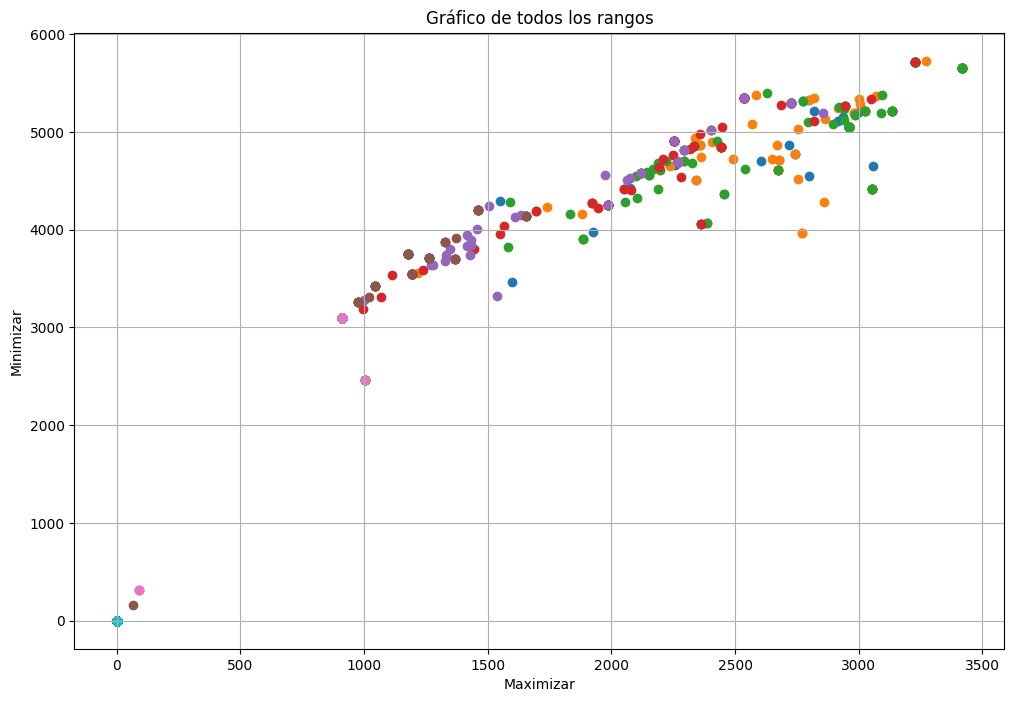

In [27]:
plt.figure(figsize=(12, 8))
plt.title('Gráfico de todos los rangos')
plt.xlabel('Maximizar')
plt.ylabel('Minimizar')

# Diferentes colores para cada rango
colors = plt.get_cmap('tab10', len(resultados))

# Iterar sobre cada conjunto de datos y agregar al gráfico
for idx, (key, values) in enumerate(resultados.items()):
    x_values = [v[0] for v in values]
    y_values = [v[1] for v in values]
    
    plt.scatter(x_values, y_values, label=f'Rango {key}', color=colors(idx))

# Mostrar leyenda y cuadrícula
# plt.legend()
plt.grid(True)
plt.show()